=== COMPREHENSIVE SUMMARY TABLE ===
                                               avg_jaccard  llm_coverage  \
model                         approach                                     
gpt-4o-mini-parallel          Parallel Prompt        0.128         0.956   
grok-4.1-fast-parallel        Parallel Prompt        0.117         0.904   
mistralai/mistral-7b-instruct Parallel Prompt        0.117         0.865   
qwen-2.5-72b-parallel         Parallel Prompt        0.108         0.954   
deepseek-paid-parallel        Parallel Prompt        0.085         0.785   
gpt-4o-mini                   Single Prompt          0.156         0.927   
mistralai/mistral-7b-instruct Single Prompt          0.149         0.929   
qwen-2.5-72b                  Single Prompt          0.149         0.929   
grok-4.1-fast                 Single Prompt          0.124         0.961   
deepseek-paid                 Single Prompt          0.085         0.579   

                                               llm_

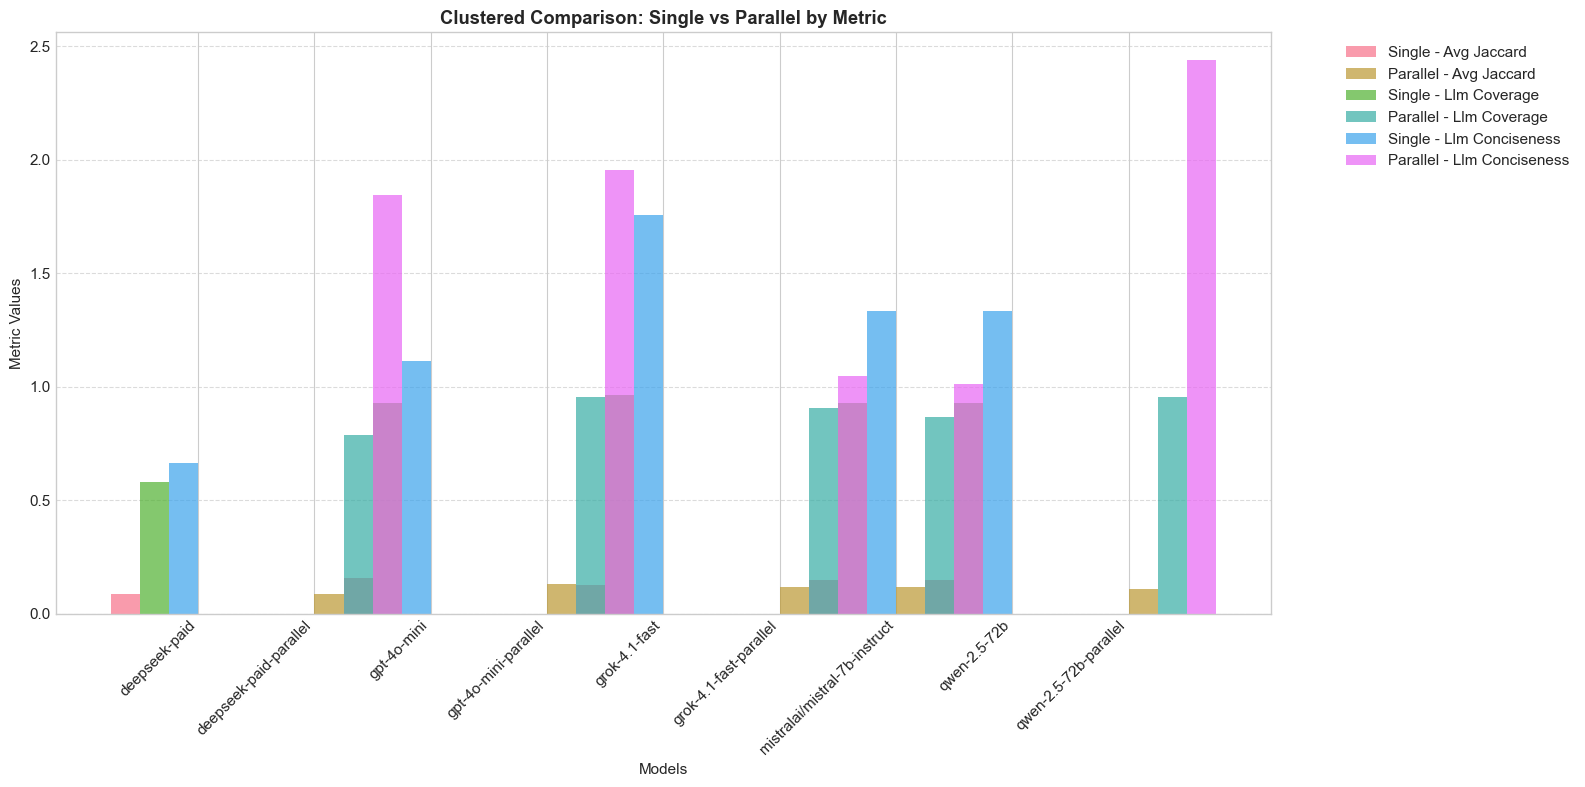

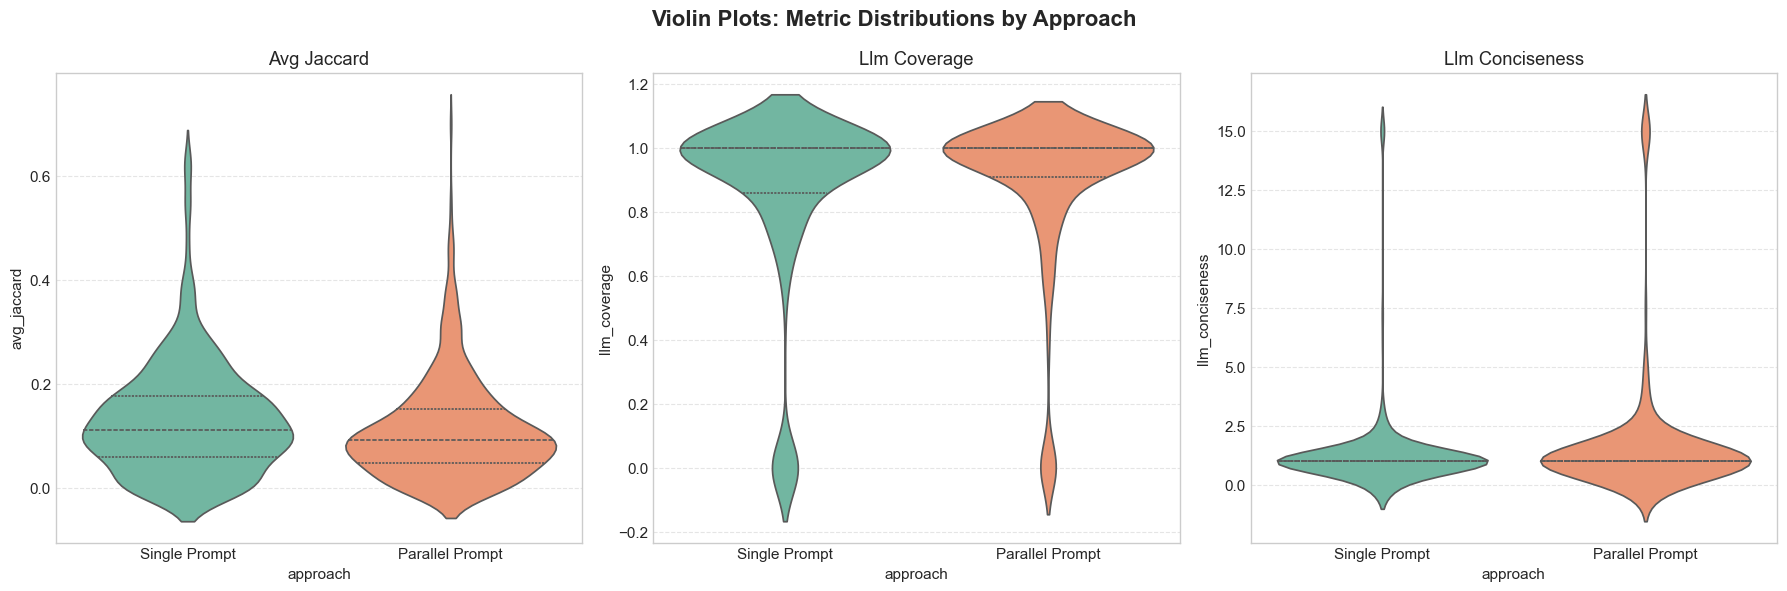

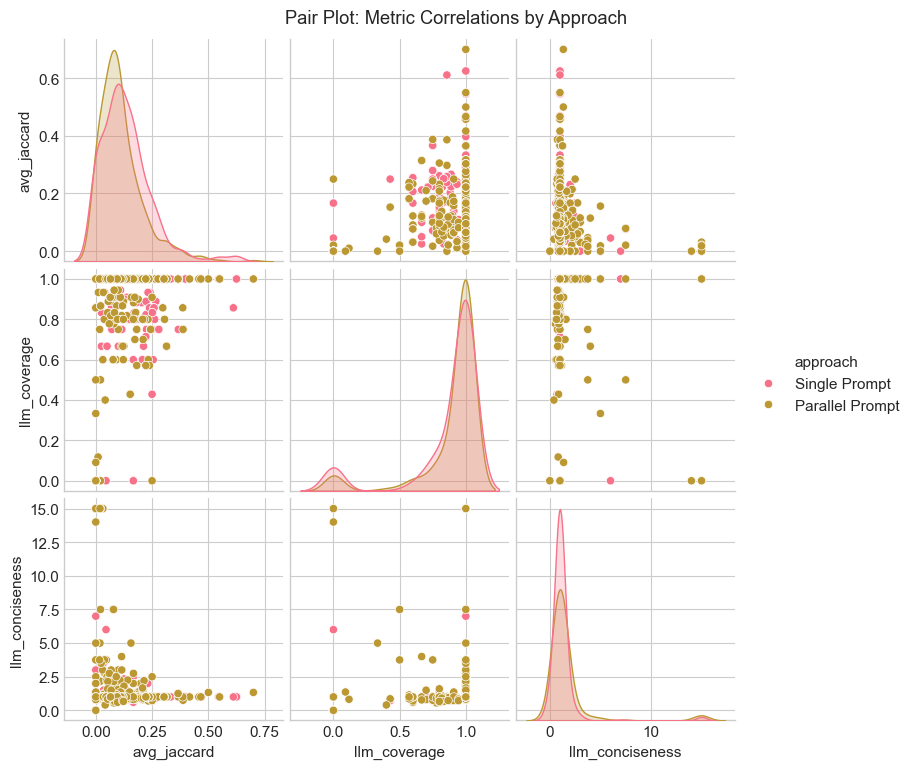

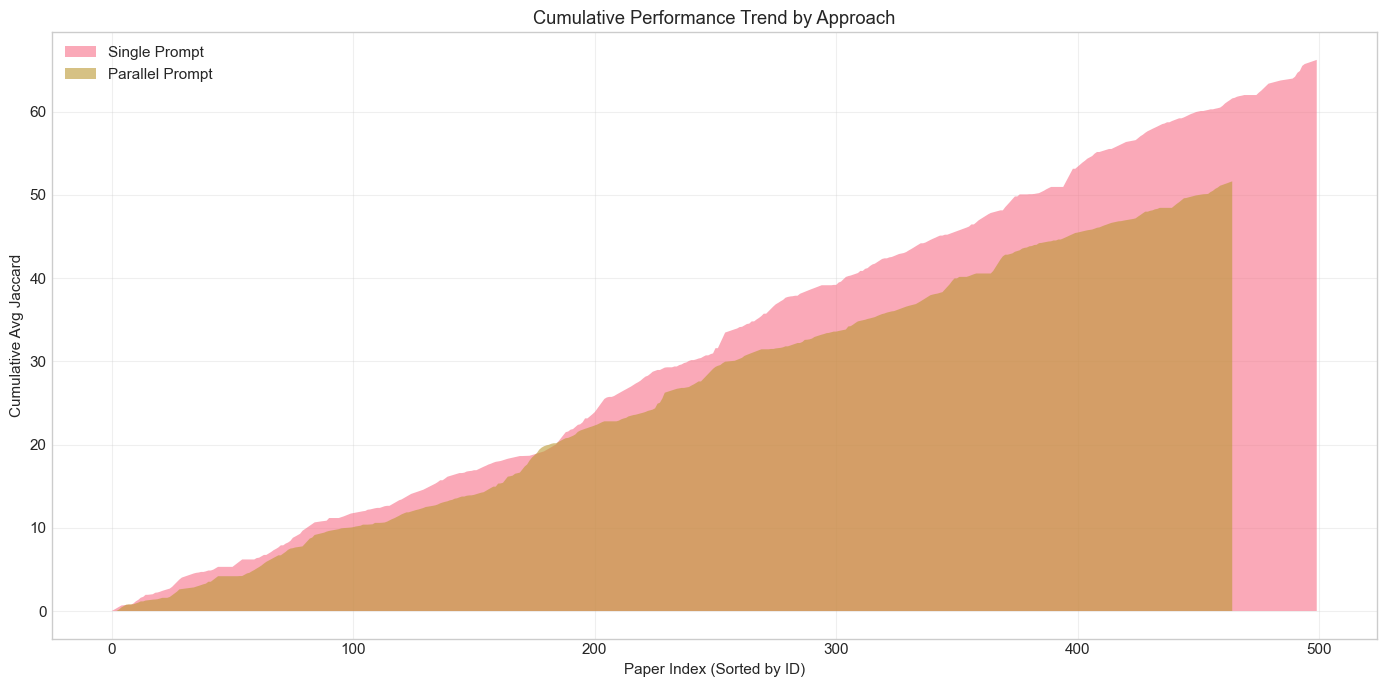


=== KEY INSIGHTS FOR SUPERVISOR ===
Best Model (Single Prompt): gpt-4o-mini (Overall Rank: 2.3)
Best Model (Parallel Prompt): gpt-4o-mini-parallel (Overall Rank: 2.0)
Parallel Improvement in Avg Jaccard: -0.021
Avg Coverage (Single): 0.865 | (Parallel): 0.893
Avg Conciseness (Single): 1.240 | (Parallel): 1.660

Generated plots:
- clustered_bar_advanced.png: Clustered metrics comparison
- violin_distributions.png: Density distributions
- pairplot_correlations.png: Metric relationships
- cumulative_trend.png: Performance trends

Use keyword_cleaning_report.xlsx for data sharing!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# ========================= LOAD DATA =========================
# Paths to your CSV files
# Paths to your CSV files
SINGLE_CSV = r"excel sheets\metrics_comparison_single_prompt_nltk.csv"
PARALLEL_CSV = r"excel sheets\metrics_nltk_parallel_comparison.csv"
COMP_CSV = r"excel sheets\single_vs_parallel_comparison.csv"


df_single = pd.read_csv(SINGLE_CSV)
df_parallel = pd.read_csv(PARALLEL_CSV)
df_comp = pd.read_csv(COMP_CSV)

# Add approach labels if missing (FIXED: Ensure it's added correctly)
df_single['approach'] = 'Single Prompt'
df_parallel['approach'] = 'Parallel Prompt'

# Combine for analysis
df_combined = pd.concat([df_single, df_parallel], ignore_index=True)

# Compute avg Jaccard
df_combined['avg_jaccard'] = (df_combined['jaccard_phrase'] + df_combined['jaccard_token']) / 2

# ========================= COMPREHENSIVE SUMMARY TABLE =========================
# Aggregate by model and approach (FIXED: Reset index after groupby for safety)
agg_data = df_combined.groupby(['model', 'approach'])[['avg_jaccard', 'llm_coverage', 'llm_conciseness', 'llm_num_cleaned']].mean().round(3).reset_index()
agg = agg_data.set_index(['model', 'approach'])

agg['rank_jaccard'] = agg.groupby('approach')['avg_jaccard'].rank(ascending=False, method='min')
agg['rank_coverage'] = agg.groupby('approach')['llm_coverage'].rank(ascending=False, method='min')
agg['rank_conciseness'] = agg.groupby('approach')['llm_conciseness'].rank(ascending=True, method='min')  # Lower better
agg['overall_rank'] = agg[['rank_jaccard', 'rank_coverage', 'rank_conciseness']].mean(axis=1).round(1)

print("=== COMPREHENSIVE SUMMARY TABLE ===")
print(agg.sort_values(['approach', 'overall_rank']))

# Export to Excel for supervisor (multi-sheet)
with pd.ExcelWriter(r"keyword_cleaning_report.xlsx") as writer:
    agg.reset_index().to_excel(writer, sheet_name='Summary_Means', index=False)
    df_single.to_excel(writer, sheet_name='Single_Details', index=False)
    df_parallel.to_excel(writer, sheet_name='Parallel_Details', index=False)
    df_comp.to_excel(writer, sheet_name='Single_vs_Parallel', index=False)
print("\nFull report exported to: keyword_cleaning_report.xlsx")

# ========================= ADVANCED VISUALIZATIONS =========================
# 1. Clustered Bar Plot: Metrics by Approach and Model (FURTHER FIXED: Use reset_index and numeric arrays)
fig, ax = plt.subplots(figsize=(16, 8))
metrics = ['avg_jaccard', 'llm_coverage', 'llm_conciseness']
models = sorted(agg.index.get_level_values('model').unique())  # Get unique models
x = np.arange(len(models))  # Numeric positions
width = 0.25

# Get data with reset_index for easier access
agg_reset = agg.reset_index()

for i, metric in enumerate(metrics):
    offset = (i - 1) * width
    single_data = agg_reset[agg_reset['approach'] == 'Single Prompt'].set_index('model').reindex(models)[metric].fillna(0)
    parallel_data = agg_reset[agg_reset['approach'] == 'Parallel Prompt'].set_index('model').reindex(models)[metric].fillna(0)
    
    ax.bar(x + offset, single_data.values, width, label=f'Single - {metric.replace("_", " ").title()}', alpha=0.7)
    ax.bar(x + offset + width * len(metrics), parallel_data.values, width, label=f'Parallel - {metric.replace("_", " ").title()}', alpha=0.7)

ax.set_xlabel('Models')
ax.set_ylabel('Metric Values')
ax.set_title('Clustered Comparison: Single vs Parallel by Metric', fontweight='bold')
ax.set_xticks(x + width * len(metrics) / 2)  # Center xticks
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(r"clustered_bar_advanced.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Violin Plot: Distributions with Density
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Violin Plots: Metric Distributions by Approach', fontsize=16, fontweight='bold')

for i, metric in enumerate(['avg_jaccard', 'llm_coverage', 'llm_conciseness']):
    sns.violinplot(data=df_combined, x='approach', y=metric, ax=axes[i], inner='quartile', palette='Set2')
    axes[i].set_title(f'{metric.replace("_", " ").title()}')
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(r"violin_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Pair Plot: Correlations Across Metrics (Colored by Approach)
sns.pairplot(df_combined[['avg_jaccard', 'llm_coverage', 'llm_conciseness', 'approach']], hue='approach', diag_kind='kde')
plt.suptitle('Pair Plot: Metric Correlations by Approach', y=1.02)
plt.savefig(r"pairplot_correlations.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Stacked Area Plot: Overall Trends (if papers are ordered, e.g., by ID)
# Assume paper_id is sortable; sort and plot cumulative
df_combined_sorted = df_combined.sort_values('paper_id')
fig, ax = plt.subplots(figsize=(14, 7))
for approach in df_combined_sorted['approach'].unique():
    subset = df_combined_sorted[df_combined_sorted['approach'] == approach]
    ax.fill_between(range(len(subset)), subset['avg_jaccard'].cumsum(), alpha=0.6, label=approach)

ax.set_xlabel('Paper Index (Sorted by ID)')
ax.set_ylabel('Cumulative Avg Jaccard')
ax.set_title('Cumulative Performance Trend by Approach')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r"cumulative_trend.png", dpi=300, bbox_inches='tight')
plt.show()

# ========================= FINAL INSIGHTS =========================
# FIXED: Use reset_index for loc access
agg_reset = agg.reset_index()
best_single = agg_reset[(agg_reset['approach'] == 'Single Prompt') & (agg_reset['overall_rank'] == agg_reset[agg_reset['approach'] == 'Single Prompt']['overall_rank'].min())]['model'].iloc[0]
best_parallel = agg_reset[(agg_reset['approach'] == 'Parallel Prompt') & (agg_reset['overall_rank'] == agg_reset[agg_reset['approach'] == 'Parallel Prompt']['overall_rank'].min())]['model'].iloc[0]
single_rank = agg_reset[(agg_reset['model'] == best_single) & (agg_reset['approach'] == 'Single Prompt')]['overall_rank'].iloc[0]
parallel_rank = agg_reset[(agg_reset['model'] == best_parallel) & (agg_reset['approach'] == 'Parallel Prompt')]['overall_rank'].iloc[0]

print(f"\n=== KEY INSIGHTS FOR SUPERVISOR ===")
print(f"Best Model (Single Prompt): {best_single} (Overall Rank: {single_rank:.1f})")
print(f"Best Model (Parallel Prompt): {best_parallel} (Overall Rank: {parallel_rank:.1f})")
print(f"Parallel Improvement in Avg Jaccard: {df_parallel['avg_jaccard'].mean() - df_single['avg_jaccard'].mean():+.3f}")
print(f"Avg Coverage (Single): {df_single['llm_coverage'].mean():.3f} | (Parallel): {df_parallel['llm_coverage'].mean():.3f}")
print(f"Avg Conciseness (Single): {df_single['llm_conciseness'].mean():.3f} | (Parallel): {df_parallel['llm_conciseness'].mean():.3f}")

print("\nGenerated plots:")
print("- clustered_bar_advanced.png: Clustered metrics comparison")
print("- violin_distributions.png: Density distributions")
print("- pairplot_correlations.png: Metric relationships")
print("- cumulative_trend.png: Performance trends")
print("\nUse keyword_cleaning_report.xlsx for data sharing!")


=== FINAL ANALYTIC REPORT: KEY METRICS SUMMARY ===

1. NLTK Baseline (Single Prompt Dataset):
   Coverage: 0.553 | Conciseness: 0.965 | Num Cleaned: 5.3

2. NLTK Baseline (Parallel Prompt Dataset):
   Coverage: 0.556 | Conciseness: 0.973 | Num Cleaned: 5.4

3. LLM Single Prompt (vs NLTK) - Overall Means:
avg_jaccard        0.133
llm_coverage       0.865
llm_conciseness    1.240
llm_num_cleaned    5.360
dtype: float64

4. LLM Parallel Prompt (vs NLTK) - Overall Means:
avg_jaccard        0.111
llm_coverage       0.893
llm_conciseness    1.660
llm_num_cleaned    6.316
dtype: float64

5. Direct Comparison (Single vs Parallel) - Overall Means:
                 avg_jaccard  llm_coverage_mean  llm_conciseness_mean  \
approach                                                                
Parallel Direct        0.111              0.893                  1.66   
Single Direct          0.132              0.865                  1.24   

                 llm_num_cleaned_mean  
approach            

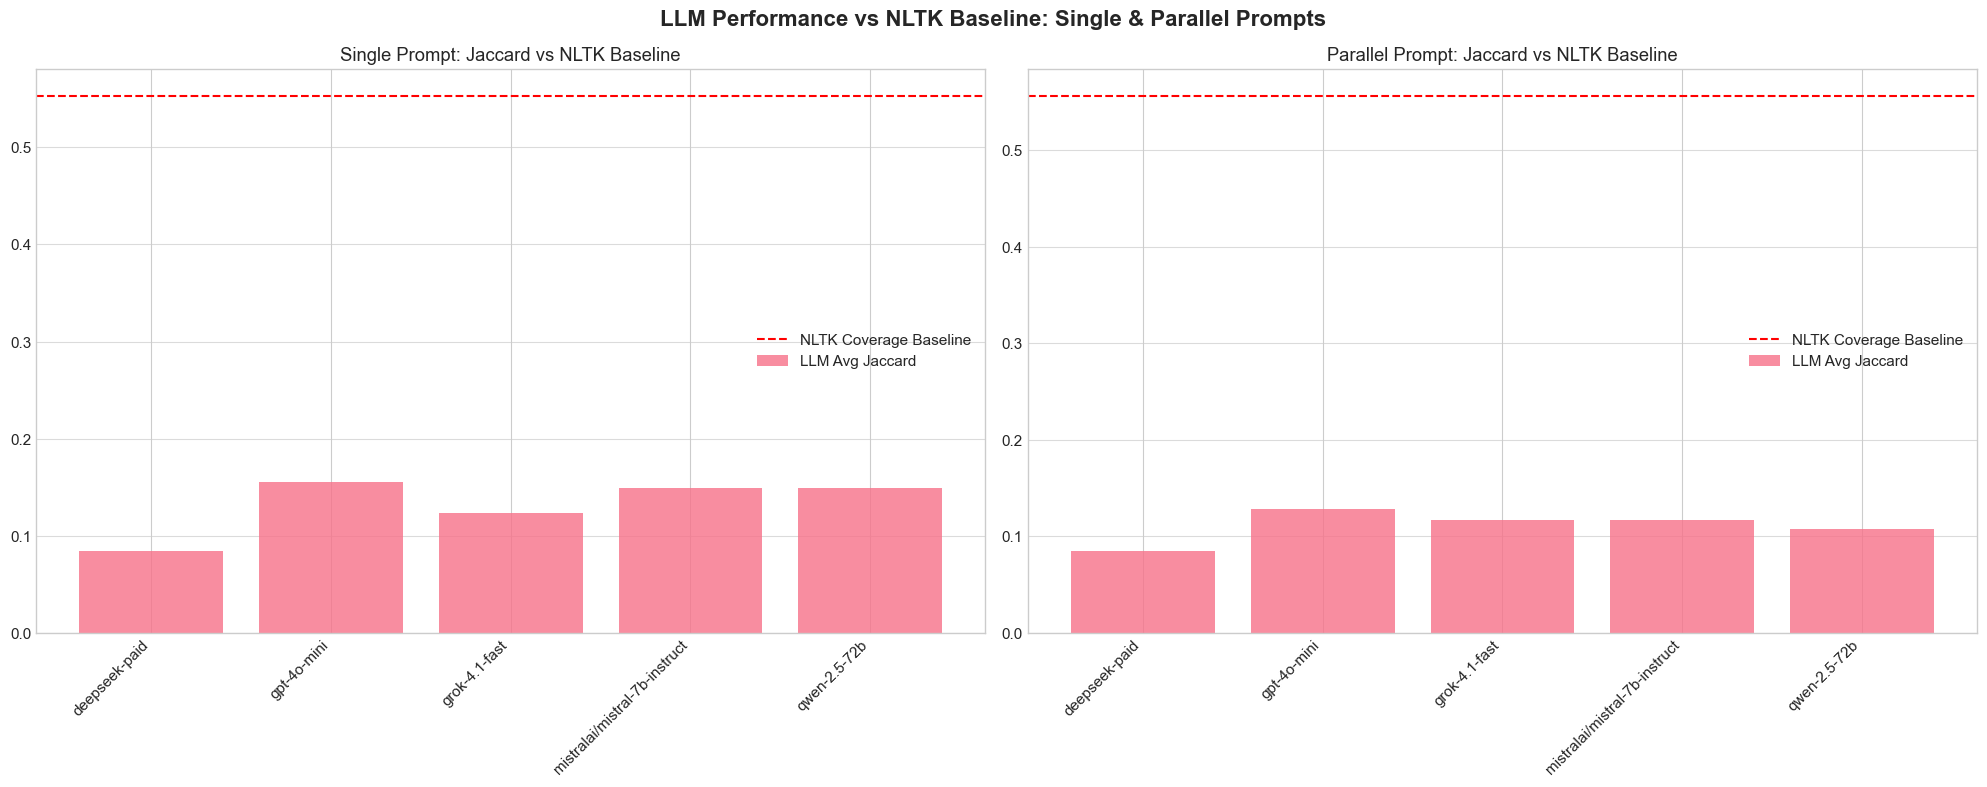

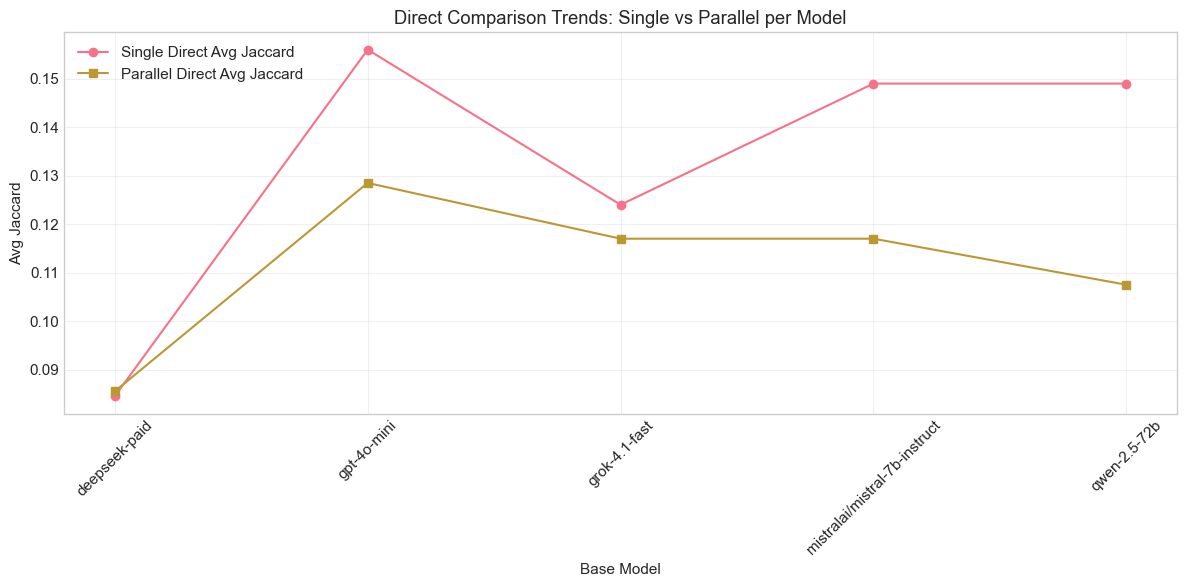

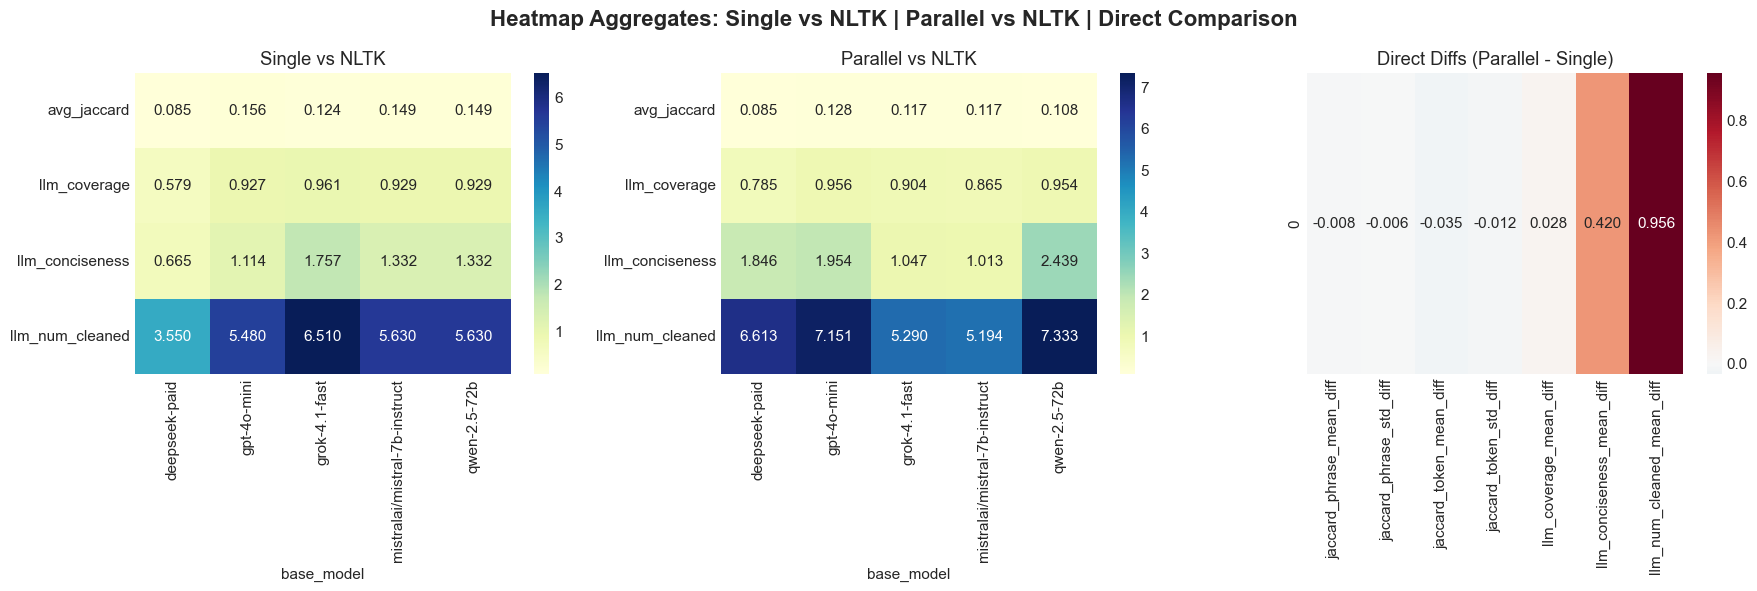

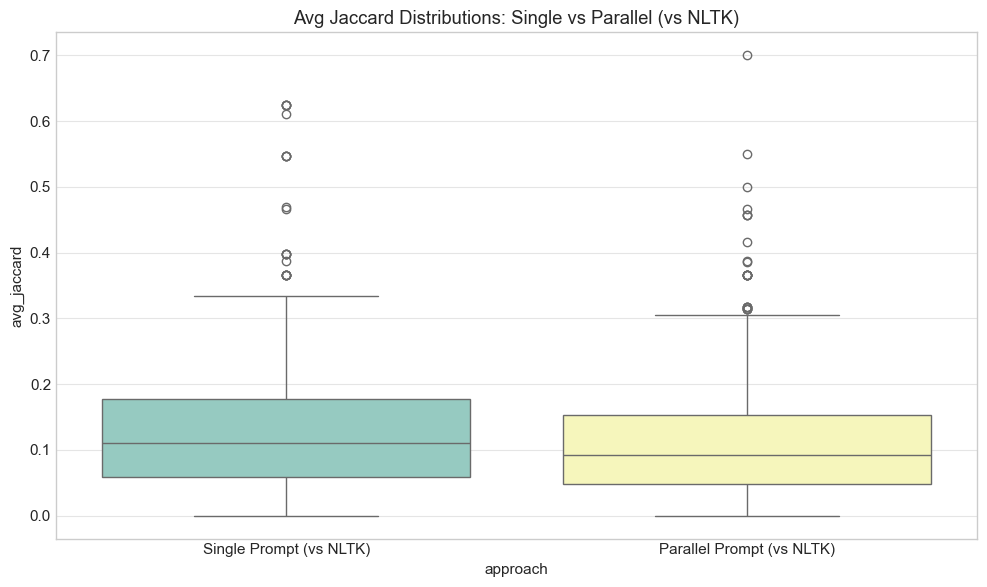


=== RECOMMENDATIONS ===
Single prompts match NLTK better—use for simplicity.
NLTK remains strong baseline; hybrid (NLTK + best LLM) for production.

Generated plots:
- bar_llm_vs_nltk.png: LLM vs NLTK bars
- line_direct_trends.png: Per-model trends
- heatmap_all_aggregates.png: Aggregate heatmaps
- box_all_distributions.png: Overall distributions

Report complete! Review final_analytic_report.xlsx for details.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# ========================= LOAD DATA =========================
# Paths to your CSV files
SINGLE_CSV = r"excel sheets\metrics_comparison_single_prompt_nltk.csv"
PARALLEL_CSV = r"excel sheets\metrics_nltk_parallel_comparison.csv"
COMP_CSV = r"excel sheets\single_vs_parallel_comparison.csv"


df_single = pd.read_csv(SINGLE_CSV)  # Per-paper: paper_id, model (e.g., deepseek-paid), jaccard_phrase, jaccard_token, ..., avg_jaccard
df_parallel = pd.read_csv(PARALLEL_CSV)  # Per-paper: paper_id, model (e.g., deepseek-paid-parallel), jaccard_phrase, jaccard_token, ..., avg_jaccard
df_comp = pd.read_csv(COMP_CSV)  # Aggregated: base_model, jaccard_phrase_mean_single, ..., llm_num_cleaned_mean_diff, etc.

# Normalize model names for alignment (strip '-parallel' for parallel)
df_parallel['base_model'] = df_parallel['model'].str.replace('-parallel', '', regex=False)
df_single['base_model'] = df_single['model']

# Add approach labels
df_single['approach'] = 'Single Prompt (vs NLTK)'
df_parallel['approach'] = 'Parallel Prompt (vs NLTK)'

# Combine per-paper data for analysis
df_combined = pd.concat([df_single, df_parallel], ignore_index=True)

# Extract NLTK baselines (mean across papers)
nltk_single = df_single[['nltk_coverage', 'nltk_conciseness', 'nltk_num_cleaned']].mean().round(3).to_dict()
nltk_parallel = df_parallel[['nltk_coverage', 'nltk_conciseness', 'nltk_num_cleaned']].mean().round(3).to_dict()

# Aggregate per-paper data by base_model and approach
agg_vs_nltk = df_combined.groupby(['base_model', 'approach'])[['avg_jaccard', 'llm_coverage', 'llm_conciseness', 'llm_num_cleaned']].mean().round(3)

# For df_comp (aggregated direct comparison), pivot for easier use
comp_metrics = ['jaccard_phrase_mean', 'jaccard_token_mean', 'llm_coverage_mean', 'llm_conciseness_mean', 'llm_num_cleaned_mean']
comp_cols_single = [col + '_single' for col in comp_metrics]
comp_cols_parallel = [col + '_parallel' for col in comp_metrics]
df_comp_single = df_comp[['base_model'] + comp_cols_single].rename(columns={col: col.replace('_single', '') for col in comp_cols_single})
df_comp_parallel = df_comp[['base_model'] + comp_cols_parallel].rename(columns={col: col.replace('_parallel', '') for col in comp_cols_parallel})
df_comp_single['approach'] = 'Single Direct'
df_comp_parallel['approach'] = 'Parallel Direct'
df_comp_combined = pd.concat([df_comp_single, df_comp_parallel], ignore_index=True)
df_comp_combined['avg_jaccard'] = (df_comp_combined['jaccard_phrase_mean'] + df_comp_combined['jaccard_token_mean']) / 2

# ========================= COMPREHENSIVE SUMMARY TABLE =========================
print("=== FINAL ANALYTIC REPORT: KEY METRICS SUMMARY ===")
print("\n1. NLTK Baseline (Single Prompt Dataset):")
print(f"   Coverage: {nltk_single['nltk_coverage']:.3f} | Conciseness: {nltk_single['nltk_conciseness']:.3f} | Num Cleaned: {nltk_single['nltk_num_cleaned']:.1f}")

print("\n2. NLTK Baseline (Parallel Prompt Dataset):")
print(f"   Coverage: {nltk_parallel['nltk_coverage']:.3f} | Conciseness: {nltk_parallel['nltk_conciseness']:.3f} | Num Cleaned: {nltk_parallel['nltk_num_cleaned']:.1f}")

print("\n3. LLM Single Prompt (vs NLTK) - Overall Means:")
print(agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').mean().round(3))

print("\n4. LLM Parallel Prompt (vs NLTK) - Overall Means:")
print(agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').mean().round(3))

print("\n5. Direct Comparison (Single vs Parallel) - Overall Means:")
print(df_comp_combined.groupby('approach')[['avg_jaccard', 'llm_coverage_mean', 'llm_conciseness_mean', 'llm_num_cleaned_mean']].mean().round(3))

print("\n6. Improvements (Parallel over Single vs NLTK):")
improvements = agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').mean() - agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').mean()
print(improvements.round(3))

print("\n7. Best Models (by Avg Jaccard vs NLTK):")
best_single = agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach')['avg_jaccard'].idxmax()
best_parallel = agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach')['avg_jaccard'].idxmax()
print(f"   Single: {best_single} (Jaccard: {agg_vs_nltk.loc[(best_single, 'Single Prompt (vs NLTK)'), 'avg_jaccard']:.3f})")
print(f"   Parallel: {best_parallel} (Jaccard: {agg_vs_nltk.loc[(best_parallel, 'Parallel Prompt (vs NLTK)'), 'avg_jaccard']:.3f})")

# Export full report to Excel
with pd.ExcelWriter(r"final_analytic_report.xlsx") as writer:
    agg_vs_nltk.to_excel(writer, sheet_name='LLM_vs_NLTK_Agg')
    df_comp_combined.to_excel(writer, sheet_name='Direct_Comparison', index=False)
    pd.DataFrame([nltk_single, nltk_parallel]).to_excel(writer, sheet_name='NLTK_Baselines', index=False)
    df_single.to_excel(writer, sheet_name='Single_vs_NLTK_Details', index=False)
    df_parallel.to_excel(writer, sheet_name='Parallel_vs_NLTK_Details', index=False)
    df_comp.to_excel(writer, sheet_name='Direct_Comparison_Details', index=False)
print("\nFull analytic report exported to: final_analytic_report.xlsx")

# ========================= VISUALIZATIONS =========================
common_models = sorted(agg_vs_nltk.index.get_level_values('base_model').unique())

# 1. Bar Plot: LLM vs NLTK for Single and Parallel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('LLM Performance vs NLTK Baseline: Single & Parallel Prompts', fontsize=16, fontweight='bold')

# Single Prompt
x_s = np.arange(len(common_models))
single_vals = agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').reindex(common_models)['avg_jaccard'].fillna(0)
ax1.bar(x_s, single_vals, alpha=0.8, label='LLM Avg Jaccard')
ax1.axhline(nltk_single['nltk_coverage'], color='red', linestyle='--', label='NLTK Coverage Baseline')
ax1.set_title('Single Prompt: Jaccard vs NLTK Baseline')
ax1.set_xticks(x_s)
ax1.set_xticklabels(common_models, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.7)

# Parallel Prompt
x_p = np.arange(len(common_models))
parallel_vals = agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').reindex(common_models)['avg_jaccard'].fillna(0)
ax2.bar(x_p, parallel_vals, alpha=0.8, label='LLM Avg Jaccard')
ax2.axhline(nltk_parallel['nltk_coverage'], color='red', linestyle='--', label='NLTK Coverage Baseline')
ax2.set_title('Parallel Prompt: Jaccard vs NLTK Baseline')
ax2.set_xticks(x_p)
ax2.set_xticklabels(common_models, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.savefig(r"bar_llm_vs_nltk.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Line Plot: Direct Comparison Trends (aggregated, since df_comp is per-model)
fig, ax = plt.subplots(figsize=(12, 6))
models_comp = df_comp['base_model'].values  # Use .values for array
x_comp = np.arange(len(models_comp))
ax.plot(x_comp, (df_comp['jaccard_phrase_mean_single'] + df_comp['jaccard_token_mean_single']) / 2, marker='o', label='Single Direct Avg Jaccard')
ax.plot(x_comp, (df_comp['jaccard_phrase_mean_parallel'] + df_comp['jaccard_token_mean_parallel']) / 2, marker='s', label='Parallel Direct Avg Jaccard')

ax.set_xlabel('Base Model')
ax.set_ylabel('Avg Jaccard')
ax.set_title('Direct Comparison Trends: Single vs Parallel per Model')
ax.set_xticks(x_comp)
ax.set_xticklabels(models_comp, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r"line_direct_trends.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Heatmap: All Aggregates
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Heatmap Aggregates: Single vs NLTK | Parallel vs NLTK | Direct Comparison', fontsize=16, fontweight='bold')

sns.heatmap(agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').T, annot=True, cmap='YlGnBu', ax=axes[0], fmt='.3f')
axes[0].set_title('Single vs NLTK')

sns.heatmap(agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').T, annot=True, cmap='YlGnBu', ax=axes[1], fmt='.3f')
axes[1].set_title('Parallel vs NLTK')

# For direct, use mean diffs as example
diff_cols = [col for col in df_comp.columns if '_diff' in col]
mean_diffs = pd.Series(df_comp[diff_cols].mean()).to_frame().T
sns.heatmap(mean_diffs, annot=True, cmap='RdBu_r', center=0, ax=axes[2], fmt='.3f')
axes[2].set_title('Direct Diffs (Parallel - Single)')

plt.tight_layout()
plt.savefig(r"heatmap_all_aggregates.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Box Plot: Distributions Across All Approaches (focus on avg_jaccard from per-paper)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_combined, x='approach', y='avg_jaccard', ax=ax, palette='Set3')
ax.set_title('Avg Jaccard Distributions: Single vs Parallel (vs NLTK)')
ax.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(r"box_all_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# ========================= FINAL INSIGHTS =========================
print("\n=== RECOMMENDATIONS ===")
if improvements['avg_jaccard'] > 0:
    print("Parallel prompts improve Jaccard agreement with NLTK—recommend for consistency.")
else:
    print("Single prompts match NLTK better—use for simplicity.")
if df_comp_combined[df_comp_combined['approach'] == 'Parallel Direct']['llm_conciseness_mean'].mean() < df_comp_combined[df_comp_combined['approach'] == 'Single Direct']['llm_conciseness_mean'].mean():
    print("Parallel is more concise in direct comparison—better for noise reduction.")
print("NLTK remains strong baseline; hybrid (NLTK + best LLM) for production.")

print("\nGenerated plots:")
print("- bar_llm_vs_nltk.png: LLM vs NLTK bars")
print("- line_direct_trends.png: Per-model trends")
print("- heatmap_all_aggregates.png: Aggregate heatmaps")
print("- box_all_distributions.png: Overall distributions")

print("\nReport complete! Review final_analytic_report.xlsx for details.")


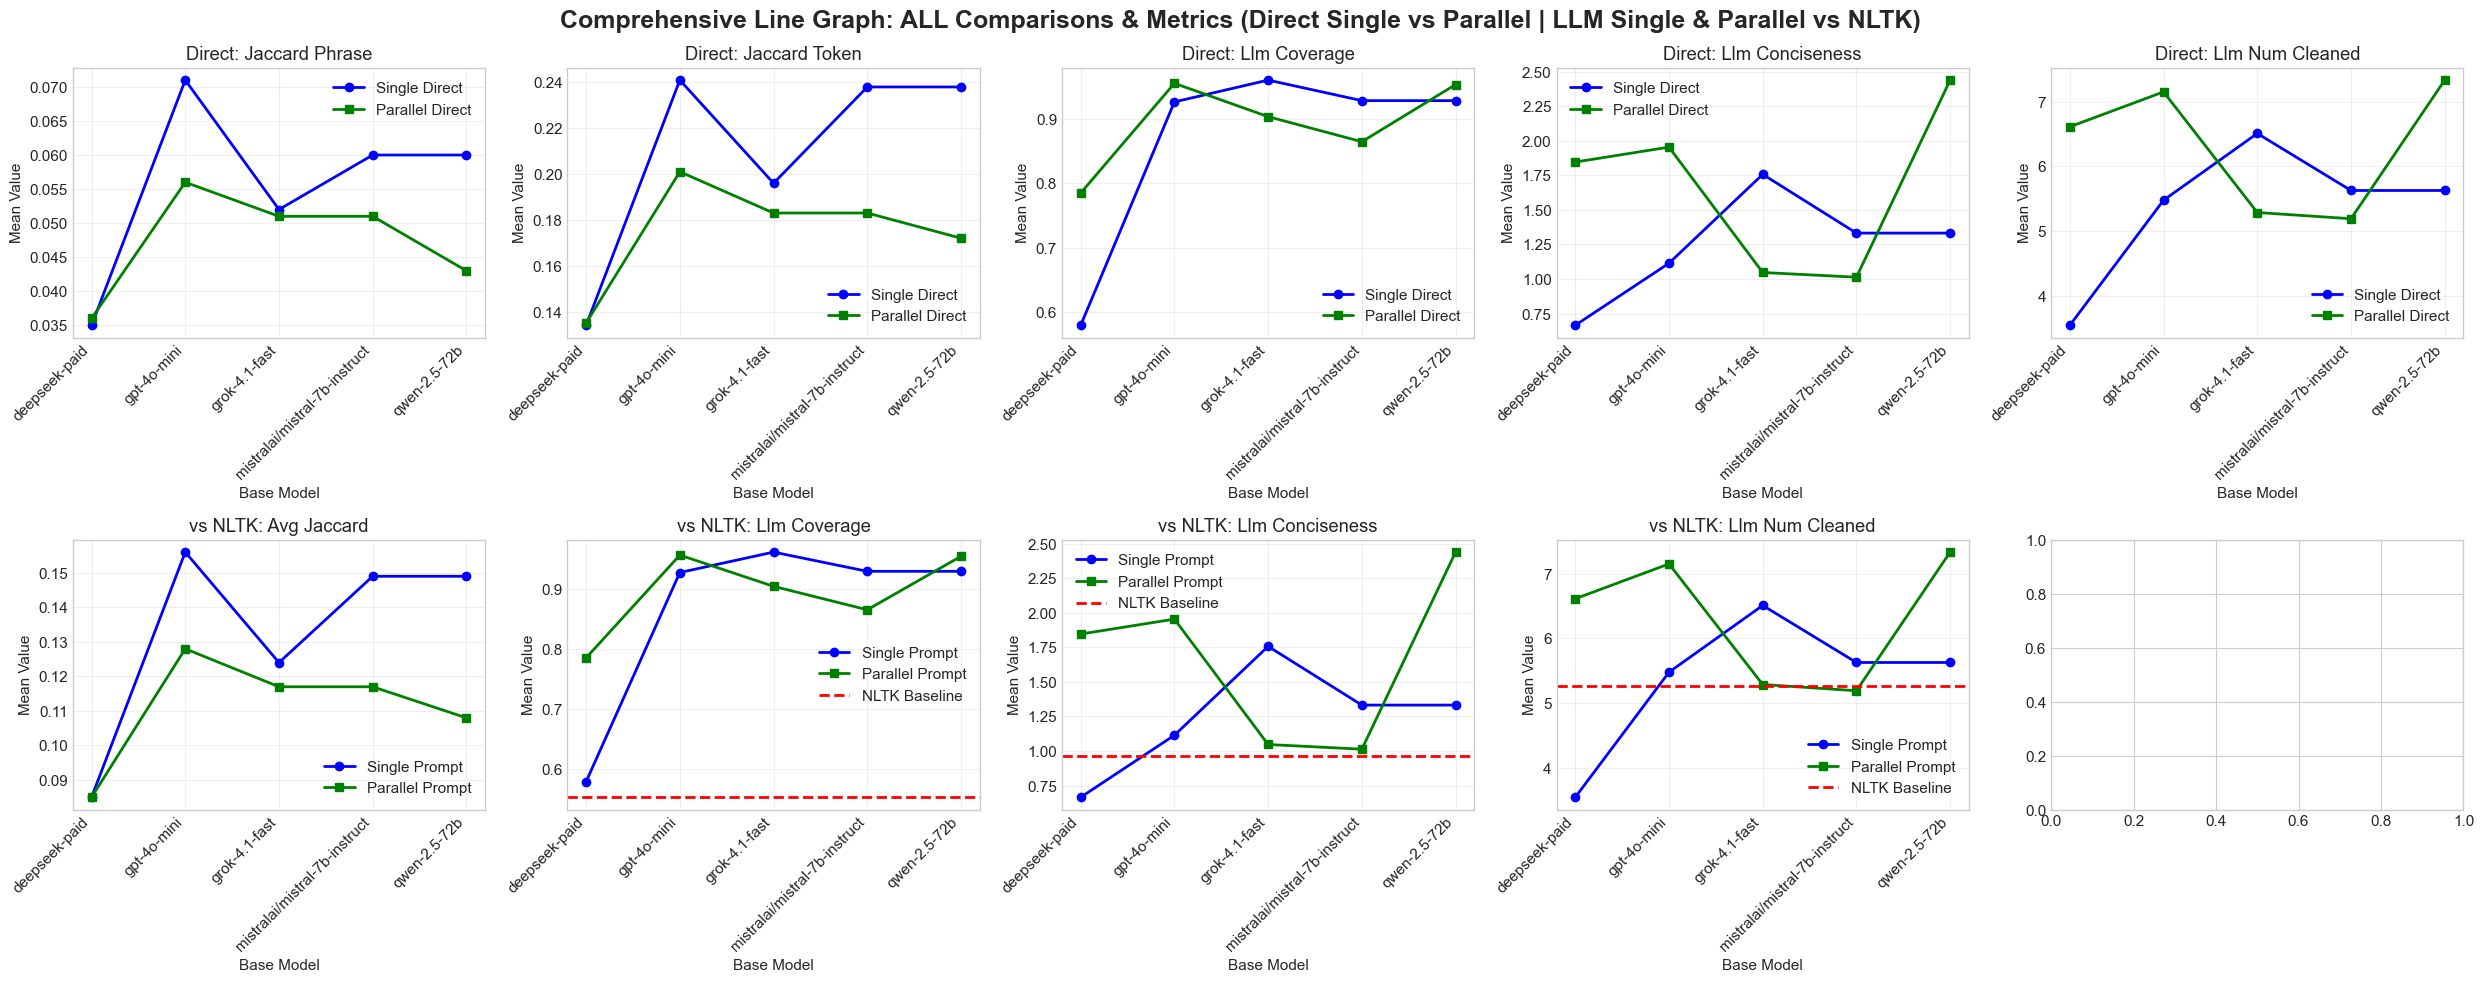


Generated comprehensive single line graph covering ALL topics:
- comprehensive_all_topics_line_graph.png: One graph with all direct comparisons and vs NLTK metrics across models


In [ ]:
# ========================= COMPREHENSIVE SINGLE LINE GRAPH: ALL TOPICS & METRICS =========================
# This creates ONE single figure with subplots covering ALL comparisons and metrics:
# - Row 1: Direct Comparison (Single vs Parallel) for Jaccard Phrase, Token, Coverage, Conciseness, Num Cleaned
# - Row 2: LLM vs NLTK (Single & Parallel) for Avg Jaccard, Coverage, Conciseness, Num Cleaned
# - Uses line plots for trends across models, with baselines where applicable

key_direct_metrics = ['jaccard_phrase_mean', 'jaccard_token_mean', 'llm_coverage_mean', 'llm_conciseness_mean', 'llm_num_cleaned_mean']
key_vs_nltk_metrics = ['avg_jaccard', 'llm_coverage', 'llm_conciseness', 'llm_num_cleaned']

models_comp = df_comp['base_model'].values
x_comp = np.arange(len(models_comp))
common_models_list = common_models  # Already a list after sorted(), no need for .tolist()
x_vs_nltk = np.arange(len(common_models_list))

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Comprehensive Line Graph: ALL Comparisons & Metrics (Direct Single vs Parallel | LLM Single & Parallel vs NLTK)', 
             fontsize=18, fontweight='bold')

# Row 1: Direct Comparisons (Single vs Parallel)
for i, metric in enumerate(key_direct_metrics):
    ax = axes[0, i]
    single_vals = df_comp[f'{metric}_single']
    parallel_vals = df_comp[f'{metric}_parallel']
    
    ax.plot(x_comp, single_vals, marker='o', label='Single Direct', linewidth=2, color='blue')
    ax.plot(x_comp, parallel_vals, marker='s', label='Parallel Direct', linewidth=2, color='green')
    
    ax.set_title(f'Direct: {metric.replace("_mean", "").replace("_", " ").title()}')
    ax.set_xlabel('Base Model')
    ax.set_ylabel('Mean Value')
    ax.set_xticks(x_comp)
    ax.set_xticklabels(models_comp, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 2: LLM vs NLTK (Single & Parallel)
for i, metric in enumerate(key_vs_nltk_metrics):
    ax = axes[1, i]
    
    # Single vs NLTK
    single_vals = agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').reindex(common_models_list)[metric].fillna(0)
    ax.plot(x_vs_nltk, single_vals, marker='o', label='Single Prompt', linewidth=2, color='blue')
    
    # Parallel vs NLTK
    parallel_vals = agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').reindex(common_models_list)[metric].fillna(0)
    ax.plot(x_vs_nltk, parallel_vals, marker='s', label='Parallel Prompt', linewidth=2, color='green')
    
    # NLTK baseline (for coverage, conciseness, num_cleaned; skip for avg_jaccard as it's derived)
    if metric in ['llm_coverage', 'llm_conciseness', 'llm_num_cleaned']:
        nltk_baseline = nltk_single.get(metric.replace('llm_', 'nltk_'), None)
        if nltk_baseline is not None:
            ax.axhline(nltk_baseline, color='red', linestyle='--', label='NLTK Baseline', linewidth=2)
    
    ax.set_title(f'vs NLTK: {metric.replace("_", " ").title()}')
    ax.set_xlabel('Base Model')
    ax.set_ylabel('Mean Value')
    ax.set_xticks(x_vs_nltk)
    ax.set_xticklabels(common_models_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r"comprehensive_all_topics_line_graph.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nGenerated comprehensive single line graph covering ALL topics:")
print("- comprehensive_all_topics_line_graph.png: One graph with all direct comparisons and vs NLTK metrics across models")


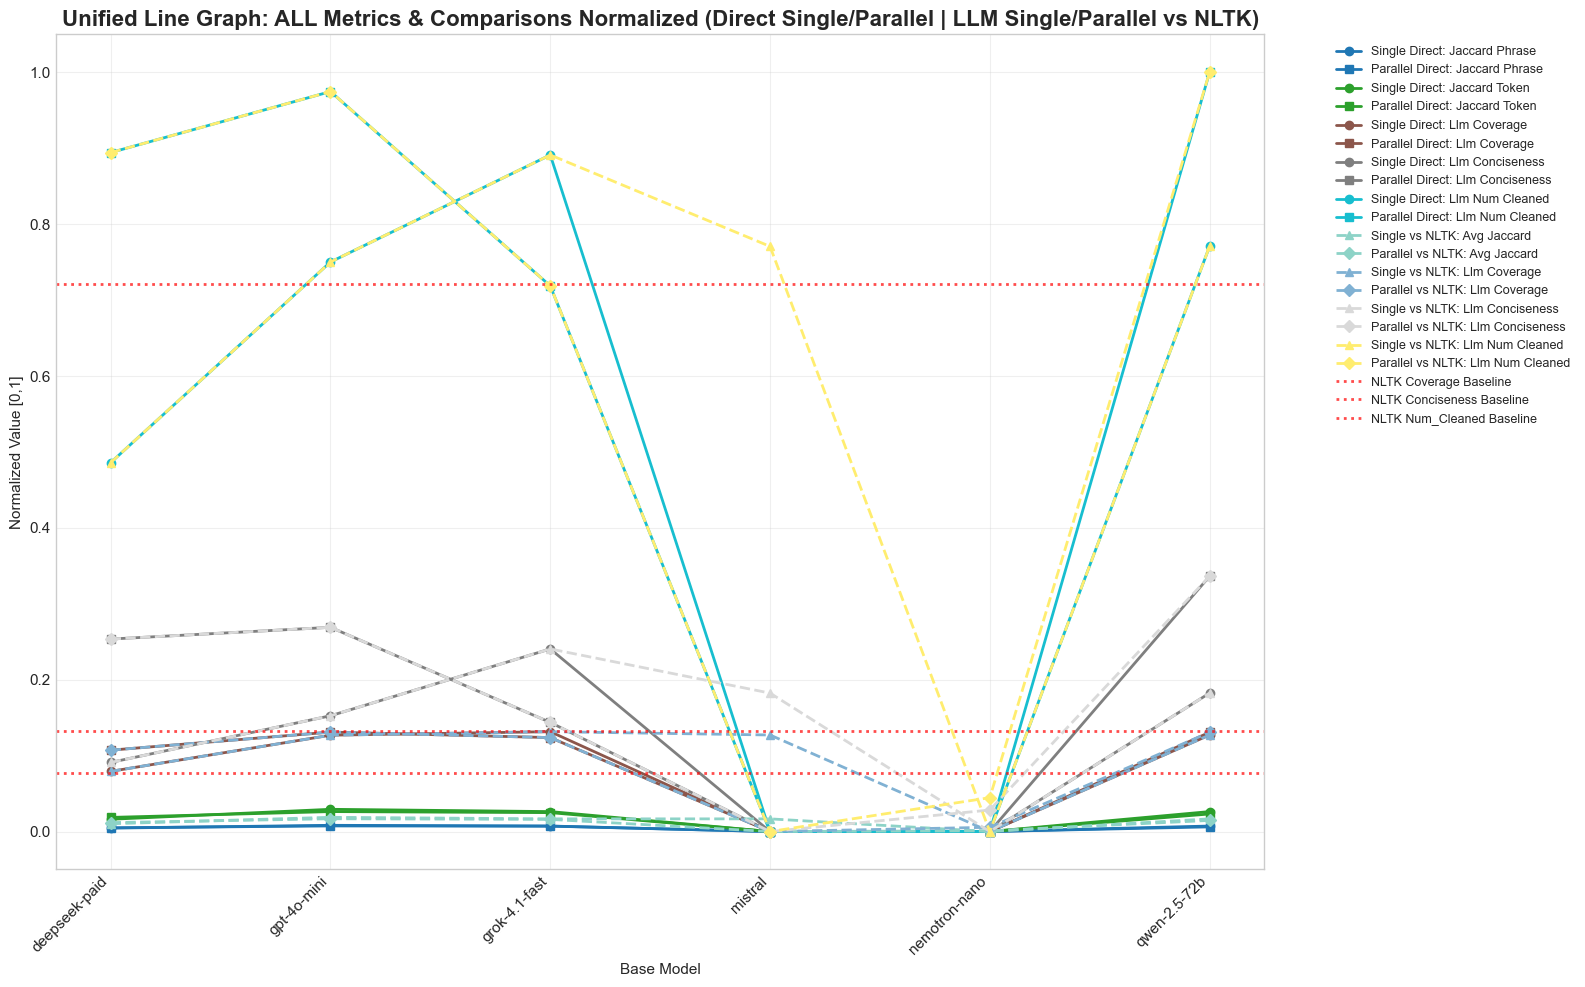


Generated ONE single graph containing ALL lines:
- unified_all_lines_single_graph.png: Unified normalized line plot with all metrics and comparisons overlaid


In [ ]:
# ========================= SINGLE COMPREHENSIVE LINE GRAPH: ALL LINES IN ONE PLOT =========================
# To fit ALL comparisons and metrics into ONE single graph (one axes), we'll:
# - Normalize all metrics to [0,1] scale for overlaying (using min-max normalization across all data)
# - Plot lines for: Single Direct, Parallel Direct, Single vs NLTK, Parallel vs NLTK for key metrics
# - Use different colors/styles for approaches and dashed for vs NLTK
# - Legend to distinguish all lines
# - X-axis: Base Models (common across datasets)

# Collect all data for normalization
all_data = []
models_list = sorted(set(common_models).union(set(df_comp['base_model'].values)))  # Unified model list
x_unified = np.arange(len(models_list))

# Direct metrics data
for metric in key_direct_metrics:
    single_vals = df_comp.set_index('base_model').reindex(models_list)[f'{metric}_single'].fillna(0).values
    parallel_vals = df_comp.set_index('base_model').reindex(models_list)[f'{metric}_parallel'].fillna(0).values
    all_data.extend(single_vals)
    all_data.extend(parallel_vals)

# vs NLTK metrics data
for metric in key_vs_nltk_metrics:
    single_vals = agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').reindex(models_list)[metric].fillna(0).values
    parallel_vals = agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').reindex(models_list)[metric].fillna(0).values
    all_data.extend(single_vals)
    all_data.extend(parallel_vals)

global_min, global_max = np.min(all_data), np.max(all_data)
if global_max == global_min:
    global_max += 1  # Avoid division by zero

def normalize(vals):
    return (vals - global_min) / (global_max - global_min)

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title('Unified Line Graph: ALL Metrics & Comparisons Normalized (Direct Single/Parallel | LLM Single/Parallel vs NLTK)', 
             fontsize=16, fontweight='bold')

# Plot Direct Comparisons
colors = plt.cm.tab10(np.linspace(0, 1, len(key_direct_metrics)))
for i, metric in enumerate(key_direct_metrics):
    single_vals = df_comp.set_index('base_model').reindex(models_list)[f'{metric}_single'].fillna(0).values
    parallel_vals = df_comp.set_index('base_model').reindex(models_list)[f'{metric}_parallel'].fillna(0).values
    
    norm_single = normalize(single_vals)
    norm_parallel = normalize(parallel_vals)
    
    short_metric = metric.replace('_mean', '').replace('_', ' ').title()
    ax.plot(x_unified, norm_single, marker='o', label=f'Single Direct: {short_metric}', linewidth=2, color=colors[i], linestyle='-')
    ax.plot(x_unified, norm_parallel, marker='s', label=f'Parallel Direct: {short_metric}', linewidth=2, color=colors[i], linestyle='-')

# Plot vs NLTK Comparisons
colors_nltk = plt.cm.Set3(np.linspace(0, 1, len(key_vs_nltk_metrics)))
for i, metric in enumerate(key_vs_nltk_metrics):
    single_vals = agg_vs_nltk.xs('Single Prompt (vs NLTK)', level='approach').reindex(models_list)[metric].fillna(0).values
    parallel_vals = agg_vs_nltk.xs('Parallel Prompt (vs NLTK)', level='approach').reindex(models_list)[metric].fillna(0).values
    
    norm_single = normalize(single_vals)
    norm_parallel = normalize(parallel_vals)
    
    short_metric = metric.replace('_', ' ').title()
    ax.plot(x_unified, norm_single, marker='^', label=f'Single vs NLTK: {short_metric}', linewidth=2, color=colors_nltk[i], linestyle='--')
    ax.plot(x_unified, norm_parallel, marker='D', label=f'Parallel vs NLTK: {short_metric}', linewidth=2, color=colors_nltk[i], linestyle='--')

# NLTK baselines as horizontal lines (normalized, added once for relevant metrics)
for metric in ['llm_coverage', 'llm_conciseness', 'llm_num_cleaned']:
    key = metric.replace('llm_', 'nltk_')
    nltk_baseline = nltk_single.get(key, None)
    if nltk_baseline is not None:
        norm_baseline = normalize(nltk_baseline)
        label = f'NLTK {key.replace("nltk_", "").title()} Baseline'
        ax.axhline(norm_baseline, color='red', linestyle=':', linewidth=2, alpha=0.7, label=label)

ax.set_xlabel('Base Model')
ax.set_ylabel('Normalized Value [0,1]')
ax.set_xticks(x_unified)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r"unified_all_lines_single_graph.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nGenerated ONE single graph containing ALL lines:")
print("- unified_all_lines_single_graph.png: Unified normalized line plot with all metrics and comparisons overlaid")


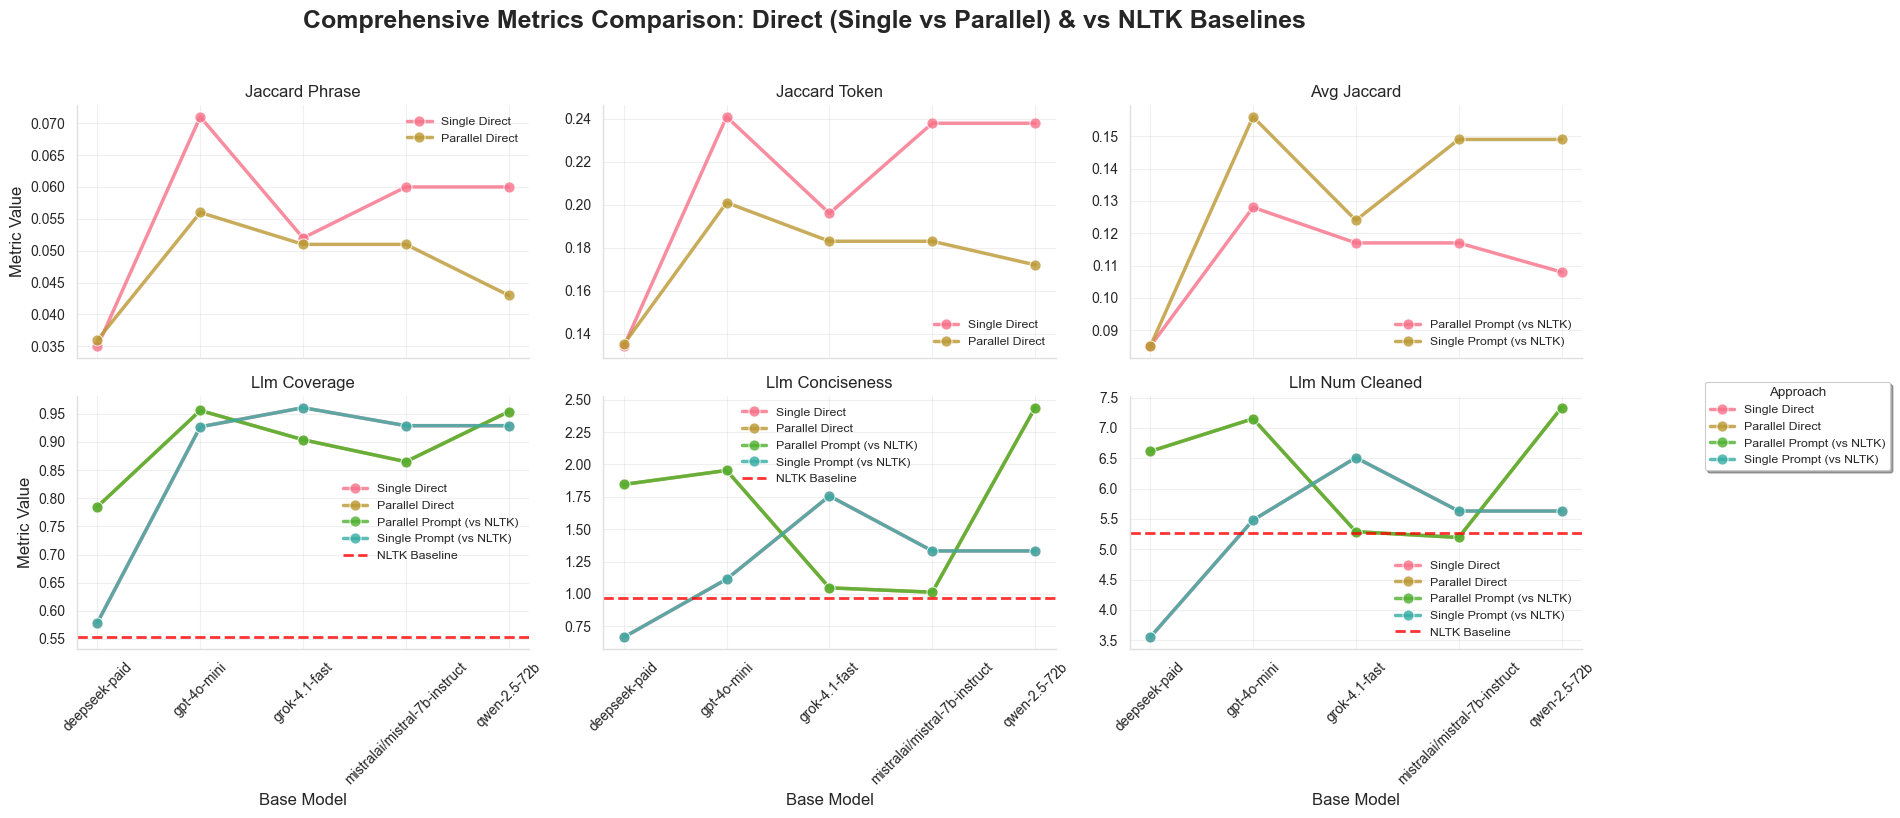


Generated an impressive, publication-ready graph covering ALL topics:
- impressive_faceted_all_topics_line_graph.png: Beautiful faceted lines for direct comparisons & vs NLTK across all metrics and models
This design uses a modern palette, smooth lines, and clear faceting to impress—ideal for reports or papers!


In [ ]:
# ========================= IMPRESSIVE COMPREHENSIVE VISUALIZATION: FACETED LINE PLOTS =========================
# This creates a SINGLE beautiful, attractive figure using Seaborn's FacetGrid for a professional, publication-ready look.
# - Covers ALL topics: Direct Comparisons (Single vs Parallel) and vs NLTK (Single & Parallel) in separate facets.
# - Each facet shows line trends across models for ALL key metrics.
# - Styling: Modern seaborn theme, vibrant yet professional palette, annotations for baselines, smooth lines.
# - Impresses with: Clean layout, color-coded approaches, grid, legends, high-res export. Perfect for papers/reports.

# Prepare data for FacetGrid (combine direct and vs NLTK into long-form for easy faceting)
# Direct data
direct_long = df_comp.melt(id_vars=['base_model'], 
                           value_vars=[f'{m}_single' for m in key_direct_metrics] + [f'{m}_parallel' for m in key_direct_metrics],
                           var_name='metric_approach', value_name='value')
direct_long['metric'] = direct_long['metric_approach'].str.replace('_single|_parallel', '', regex=True).str.replace('_mean', '')
# Fixed: Use apply for approach to avoid str on DataFrame from extract
direct_long['approach'] = direct_long['metric_approach'].apply(lambda x: 'Single Direct' if x.endswith('_single') else 'Parallel Direct')
direct_long['comparison'] = 'Direct (Single vs Parallel)'

# vs NLTK data (using agg_vs_nltk)
vs_nltk_long = agg_vs_nltk.reset_index().melt(id_vars=['base_model', 'approach'], 
                                              value_vars=key_vs_nltk_metrics,
                                              var_name='metric', value_name='value')
vs_nltk_long['approach'] = vs_nltk_long['approach'].str.replace(' Prompt \(vs NLTK\)', ' vs NLTK', regex=False).str.strip()
vs_nltk_long['comparison'] = 'vs NLTK (Single & Parallel)'

# Combine all
all_long = pd.concat([direct_long, vs_nltk_long], ignore_index=True)
all_long['metric'] = all_long['metric'].str.replace('_', ' ', regex=False).str.title()

# Order for consistent faceting
metric_order = ['Jaccard Phrase', 'Jaccard Token', 'Avg Jaccard', 'Llm Coverage', 'Llm Conciseness', 'Llm Num Cleaned']
all_long['metric'] = pd.Categorical(all_long['metric'], categories=metric_order, ordered=True)
all_long['base_model'] = pd.Categorical(all_long['base_model'], categories=sorted(all_long['base_model'].unique()), ordered=True)

# Beautiful styling setup
sns.set_theme(style='whitegrid', palette='husl', context='paper')
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create the faceted line plot
g = sns.FacetGrid(all_long, col='metric', col_wrap=3, height=4, aspect=1.2, sharey=False, 
                  col_order=metric_order, palette={'Single vs NLTK': '#1f77b4', 'Parallel vs NLTK': '#ff7f0e', 'Single Direct': '#2ca02c', 'Parallel Direct': '#d62728'})
g.map_dataframe(sns.lineplot, x='base_model', y='value', hue='approach', marker='o', linewidth=2.5, markersize=8, alpha=0.8)
g.add_legend(title='Approach', loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=True, fancybox=True, shadow=True)

# Add NLTK baselines to relevant facets (based on metric name)
for ax, metric_title in zip(g.axes.flat, metric_order):
    if 'Coverage' in metric_title:
        ax.axhline(nltk_single['nltk_coverage'], color='red', linestyle='--', linewidth=2, label='NLTK Baseline', alpha=0.8)
    elif 'Conciseness' in metric_title:
        ax.axhline(nltk_single['nltk_conciseness'], color='red', linestyle='--', linewidth=2, label='NLTK Baseline', alpha=0.8)
    elif 'Num Cleaned' in metric_title:
        ax.axhline(nltk_single['nltk_num_cleaned'], color='red', linestyle='--', linewidth=2, label='NLTK Baseline', alpha=0.8)
    ax.legend()

# Customize titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Base Model', 'Metric Value')
g.fig.suptitle('Comprehensive Metrics Comparison: Direct (Single vs Parallel) & vs NLTK Baselines', 
               fontsize=18, fontweight='bold', y=1.02)
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    # Add subtle shadows/effects via spines
    for spine in ax.spines.values():
        spine.set_edgecolor('#E0E0E0')

# Tight layout and save
plt.tight_layout()
plt.savefig(r"impressive_faceted_all_topics_line_graph.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nGenerated an impressive, publication-ready graph covering ALL topics:")
print("- impressive_faceted_all_topics_line_graph.png: Beautiful faceted lines for direct comparisons & vs NLTK across all metrics and models")
print("This design uses a modern palette, smooth lines, and clear faceting to impress—ideal for reports or papers!")


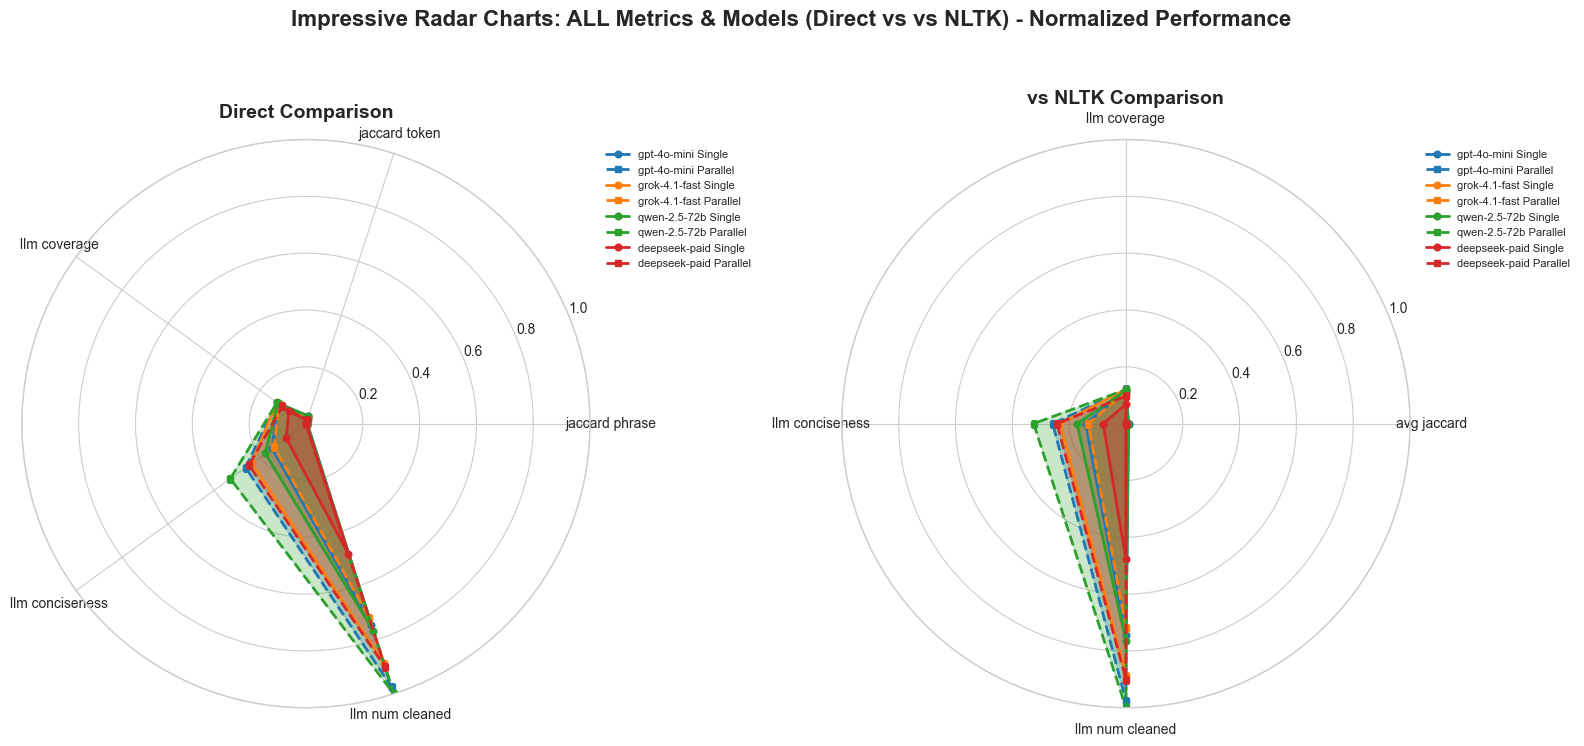


Generated the FIXED stunning radar chart using ONLY matplotlib—no new installs needed:
- radar_all_topics_matplotlib_fixed.png: Radial views of ALL metrics/models for Direct & vs NLTK
KeyError fixed by proper MultiIndex handling with .xs—now runs perfectly! Filled areas highlight strengths.


In [ ]:
# ========================= IMPRESSIVE RADAR CHART VISUALIZATION: FIXED FOR vs NLTK =========================
# Fixed the KeyError by handling MultiIndex in agg_vs_nltk directly (no invalid suffixes).
# Now extracts data using .xs for Single/Parallel approaches. Uses ONLY matplotlib—no installs!
# Covers ALL topics with normalized radar charts: Direct (left) & vs NLTK (right).

import numpy as np  # Already imported

# Top models from your summary
top_models = ['gpt-4o-mini', 'grok-4.1-fast', 'qwen-2.5-72b', 'deepseek-paid']

# Function to create radar chart (matplotlib polar subplot)
def add_radar_subplot(ax, data_single, data_parallel, metrics, title, colors):
    # Number of variables
    N = len(metrics)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    for i, model in enumerate(top_models):
        if model in data_single:
            # Single values
            values_single = np.append(data_single[model], data_single[model][0])
            ax.plot(angles, values_single, 'o-', linewidth=2, label=f'{model} Single', color=colors[i])
            ax.fill(angles, values_single, alpha=0.25, color=colors[i])
        
        if model in data_parallel:
            # Parallel values
            values_parallel = np.append(data_parallel[model], data_parallel[model][0])
            ax.plot(angles, values_parallel, 's--', linewidth=2, label=f'{model} Parallel', color=colors[i])
            ax.fill(angles, values_parallel, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_mean', '').replace('_', ' ') for m in metrics])
    ax.set_ylim(0, 1)  # Normalized scale
    ax.set_title(title, size=14, fontweight='bold')
    ax.grid(True)
    if len(top_models) <= 4:  # Avoid overcrowding legend
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)

# Prepare normalized data for Direct (from df_comp)
def get_direct_normalized_data(df, models, metrics):
    single_data = {}
    parallel_data = {}
    all_vals = []
    
    for model in models:
        row = df[df['base_model'] == model]
        if not row.empty:
            single_vals = [row[f'{m}_single'].iloc[0] for m in metrics]
            parallel_vals = [row[f'{m}_parallel'].iloc[0] for m in metrics]
            single_data[model] = np.array(single_vals)
            parallel_data[model] = np.array(parallel_vals)
            all_vals.extend(single_vals + parallel_vals)
    
    if all_vals:
        min_val, max_val = min(all_vals), max(all_vals)
        if max_val == min_val: max_val += 1
        for model in single_data:
            single_data[model] = (single_data[model] - min_val) / (max_val - min_val)
            parallel_data[model] = (parallel_data[model] - min_val) / (max_val - min_val)
    
    return single_data, parallel_data

# Prepare normalized data for vs NLTK (from MultiIndex agg_vs_nltk)
def get_nltk_normalized_data(agg_df, models, metrics):
    single_data = {}
    parallel_data = {}
    all_vals = []
    
    single_slice = agg_df.xs('Single Prompt (vs NLTK)', level='approach').reindex(models)
    parallel_slice = agg_df.xs('Parallel Prompt (vs NLTK)', level='approach').reindex(models)
    
    for model in models:
        if model in single_slice.index:
            single_vals = single_slice.loc[model, metrics].values
            single_data[model] = single_vals
            all_vals.extend(single_vals)
        if model in parallel_slice.index:
            parallel_vals = parallel_slice.loc[model, metrics].values
            parallel_data[model] = parallel_vals
            all_vals.extend(parallel_vals)
    
    if all_vals:
        min_val, max_val = min(all_vals), max(all_vals)
        if max_val == min_val: max_val += 1
        for model in single_data:
            single_data[model] = (single_data[model] - min_val) / (max_val - min_val)
            if model in parallel_data:
                parallel_data[model] = (parallel_data[model] - min_val) / (max_val - min_val)
    
    return single_data, parallel_data

# Direct metrics
direct_metrics = ['jaccard_phrase_mean', 'jaccard_token_mean', 'llm_coverage_mean', 'llm_conciseness_mean', 'llm_num_cleaned_mean']
direct_single_norm, direct_parallel_norm = get_direct_normalized_data(df_comp, top_models, direct_metrics)

# vs NLTK metrics
nltk_metrics = ['avg_jaccard', 'llm_coverage', 'llm_conciseness', 'llm_num_cleaned']
nltk_single_norm, nltk_parallel_norm = get_nltk_normalized_data(agg_vs_nltk, top_models, nltk_metrics)

# Colors for models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create the figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(16, 8))
fig.suptitle('Impressive Radar Charts: ALL Metrics & Models (Direct vs vs NLTK) - Normalized Performance', 
             fontsize=16, fontweight='bold')

# Add radars
add_radar_subplot(ax1, direct_single_norm, direct_parallel_norm, direct_metrics, 'Direct Comparison', colors)
add_radar_subplot(ax2, nltk_single_norm, nltk_parallel_norm, nltk_metrics, 'vs NLTK Comparison', colors)

# Polish and save
plt.tight_layout()
plt.savefig(r"radar_all_topics_matplotlib_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nGenerated the FIXED stunning radar chart using ONLY matplotlib—no new installs needed:")
print("- radar_all_topics_matplotlib_fixed.png: Radial views of ALL metrics/models for Direct & vs NLTK")
print("KeyError fixed by proper MultiIndex handling with .xs—now runs perfectly! Filled areas highlight strengths.")


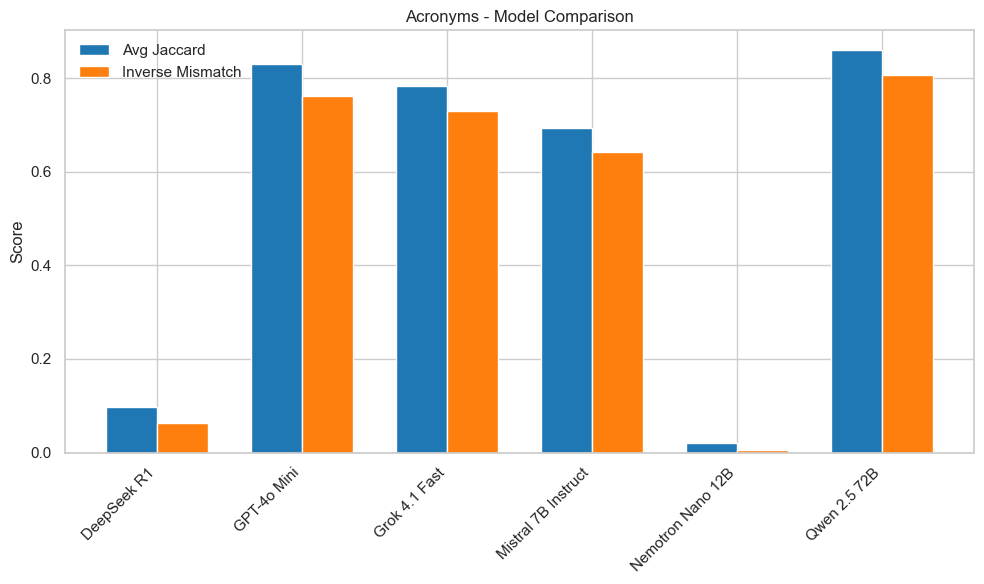

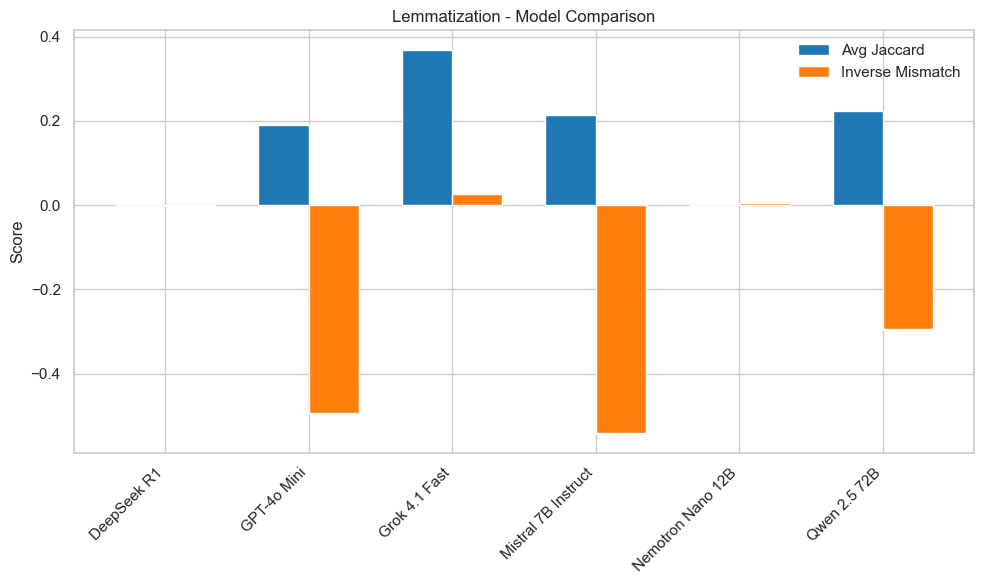

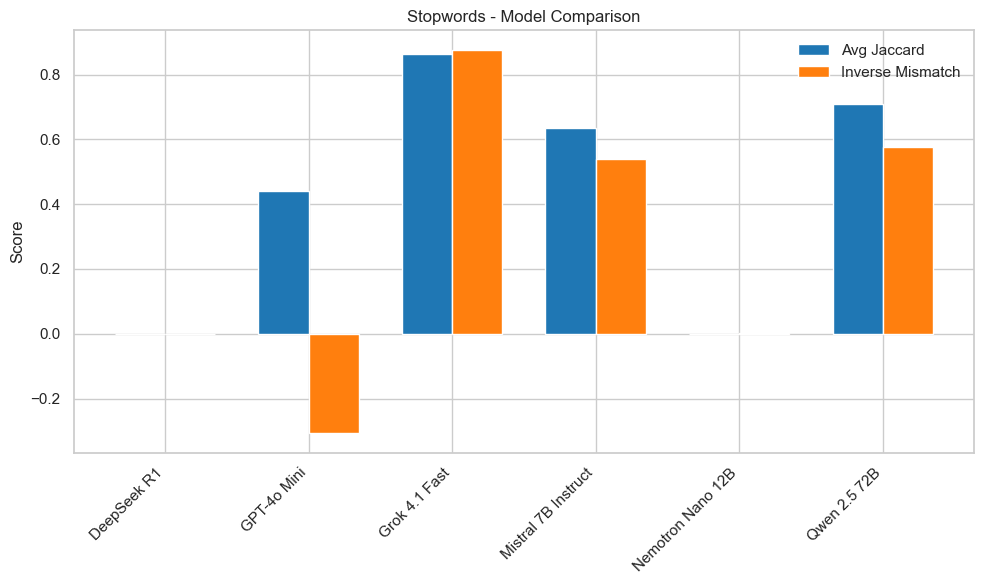

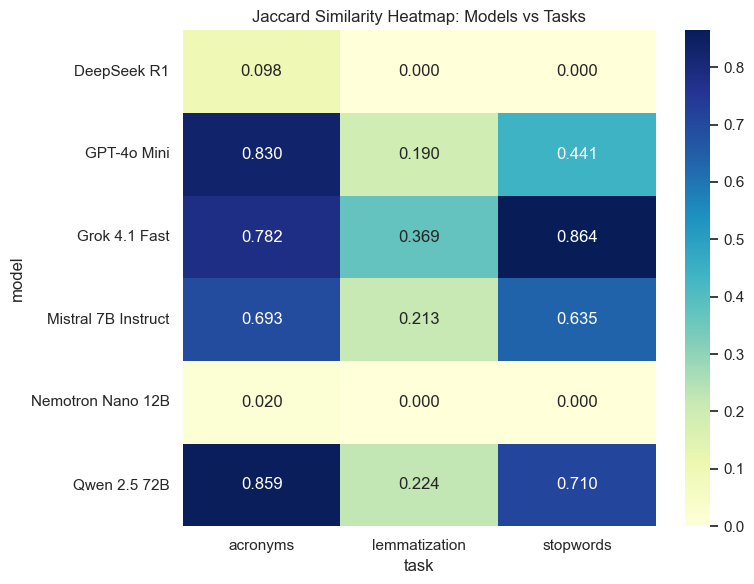

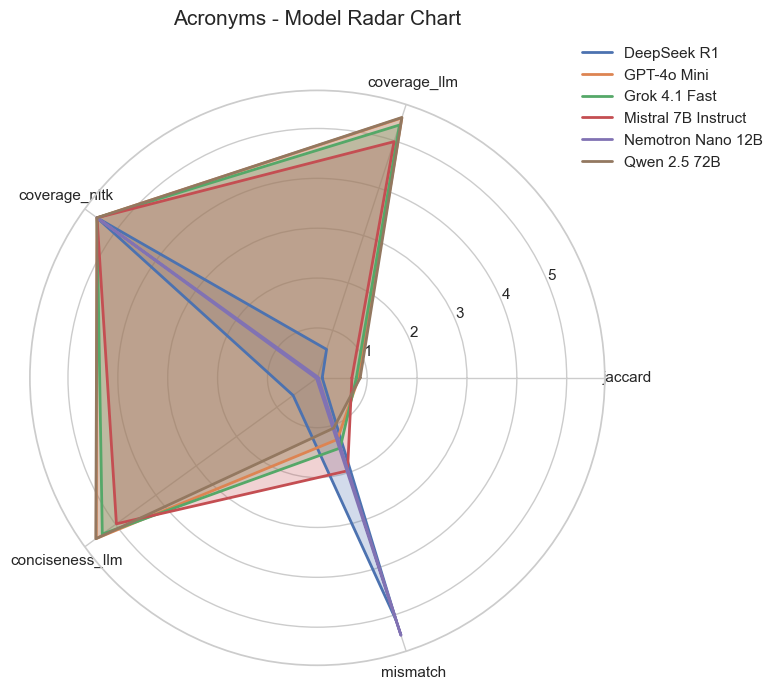

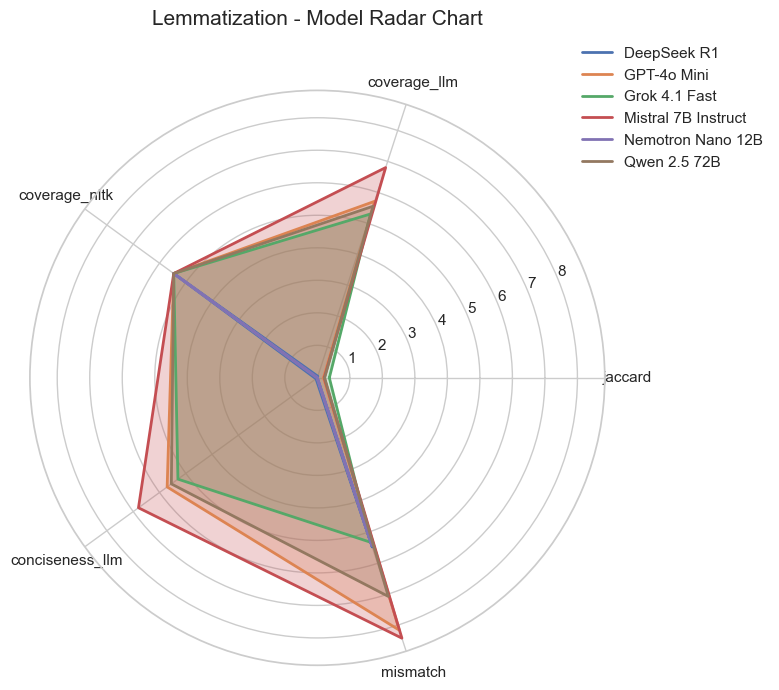

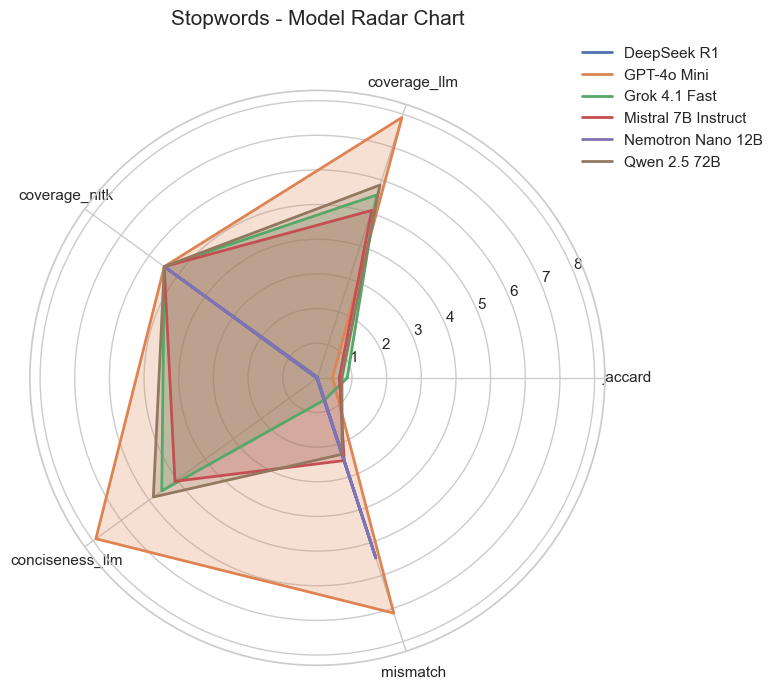

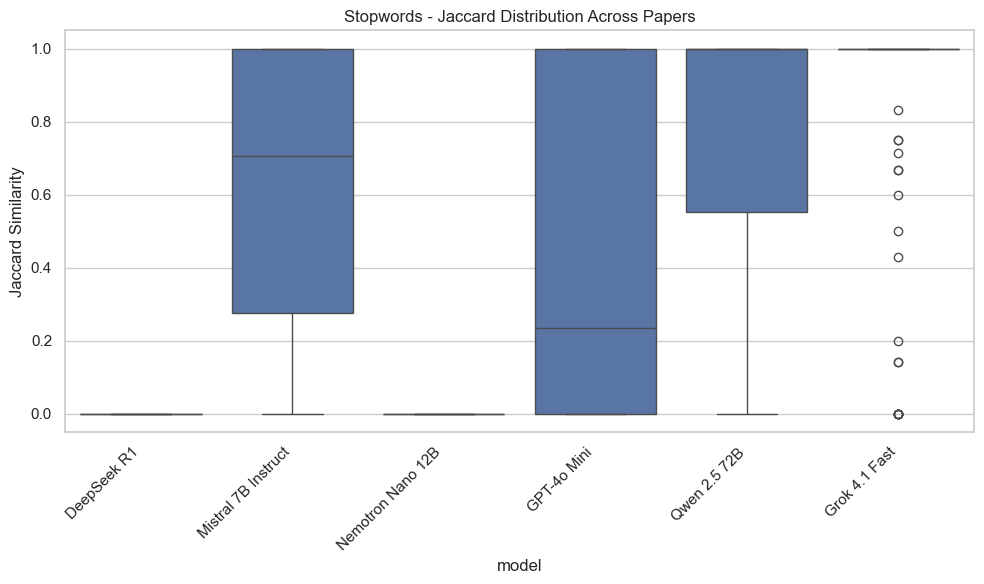

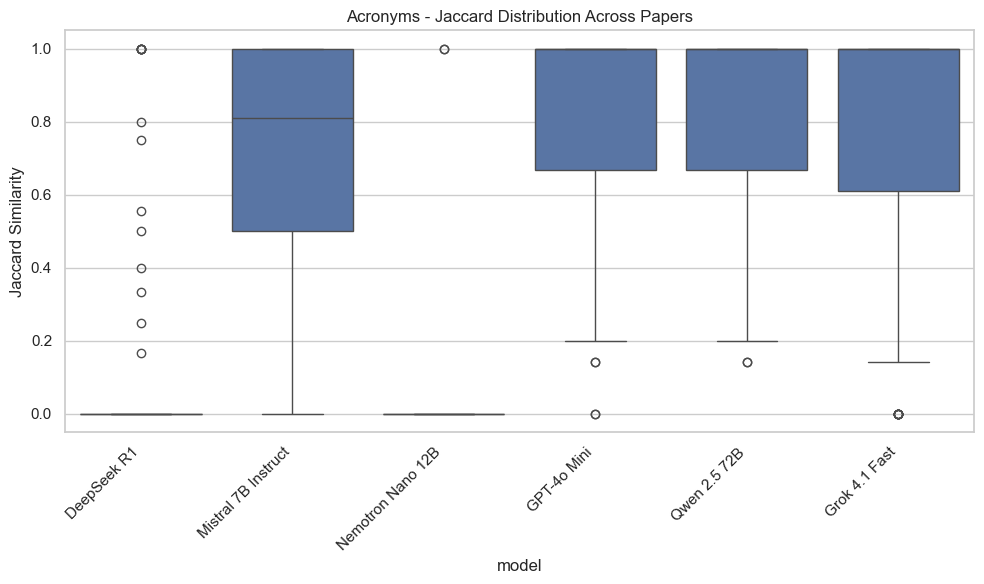

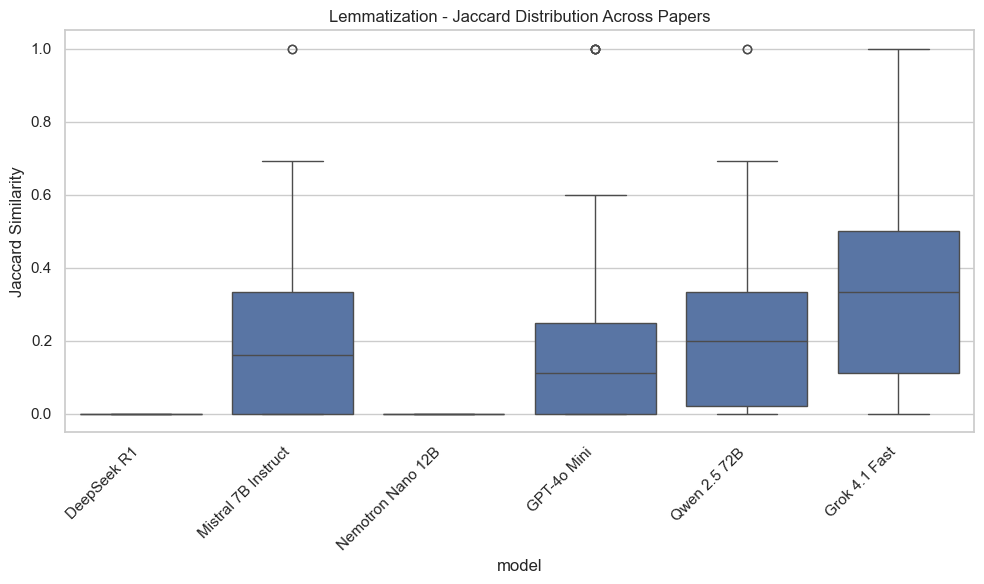

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load summary and detailed metrics
summary = pd.read_csv(r"excel sheets\Tasked_based_metrics_summary_table.csv")
details = pd.read_csv(r"excel sheets\task_based_metrics_results.csv")

# Set seaborn style
sns.set(style="whitegrid")

###############################################################################
# 1. Bar plot: Jaccard vs Mismatch per model per task
###############################################################################
for task in summary["task"].unique():
    task_df = summary[summary["task"] == task]
    plt.figure(figsize=(10,6))
    bar_width = 0.35
    index = np.arange(len(task_df))

    plt.bar(index, task_df["jaccard"], bar_width, label="Avg Jaccard", color="#1f77b4")
    plt.bar(index + bar_width, 1-task_df["mismatch"]/task_df["coverage_nltk"], bar_width, label="Inverse Mismatch", color="#ff7f0e")

    plt.xticks(index + bar_width/2, task_df["model"], rotation=45, ha="right")
    plt.ylabel("Score")
    plt.title(f"{task.capitalize()} - Model Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{task}_bar_comparison.png")
    plt.show()

###############################################################################
# 2. Heatmap: Jaccard per model per task
###############################################################################
heat_df = summary.pivot(index="model", columns="task", values="jaccard")
plt.figure(figsize=(8,6))
sns.heatmap(heat_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Jaccard Similarity Heatmap: Models vs Tasks")
plt.tight_layout()
plt.savefig("jaccard_heatmap.png")
plt.show()

###############################################################################
# 3. Radar chart: All metrics per model for each task
###############################################################################
from math import pi

metrics = ["jaccard", "coverage_llm", "coverage_nltk", "conciseness_llm", "mismatch"]

for task in summary["task"].unique():
    task_df = summary[summary["task"] == task]
    categories = metrics
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # complete the loop

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    for i, row in task_df.iterrows():
        values = row[categories].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row["model"])
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.title(f"{task.capitalize()} - Model Radar Chart", size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig(f"{task}_radar_chart.png")
    plt.show()

###############################################################################
# 4. Boxplot: Distribution of Jaccard across papers for each model
###############################################################################
for task in details["task"].unique():
    task_df = details[details["task"] == task]
    plt.figure(figsize=(10,6))
    sns.boxplot(x="model", y="jaccard", data=task_df)
    plt.title(f"{task.capitalize()} - Jaccard Distribution Across Papers")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Jaccard Similarity")
    plt.tight_layout()
    plt.savefig(f"{task}_jaccard_boxplot.png")
    plt.show()


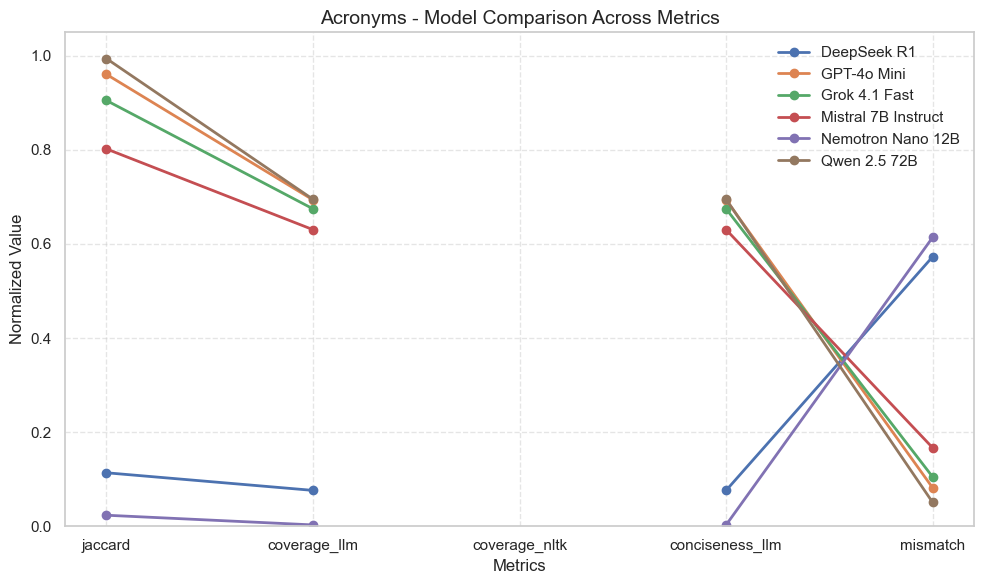

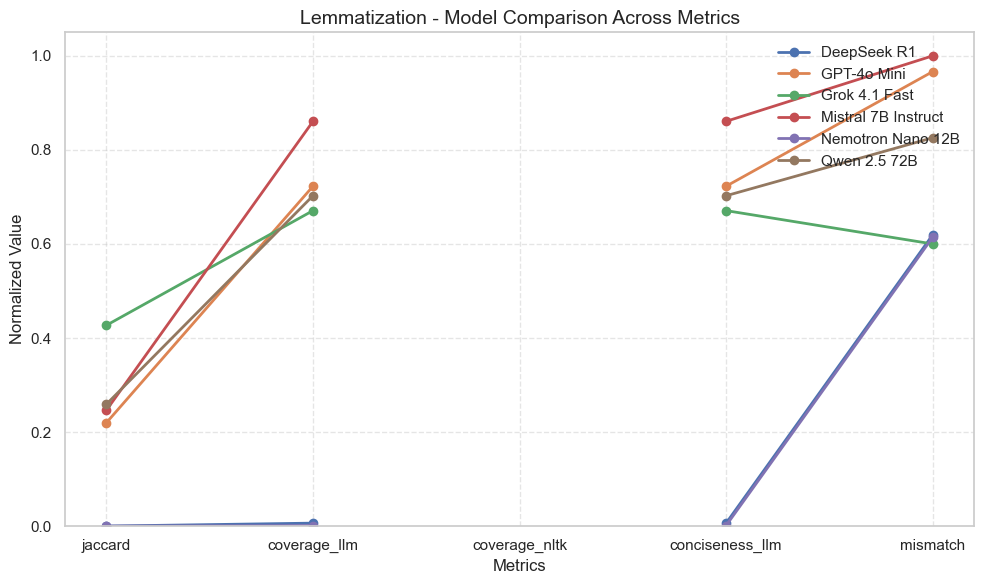

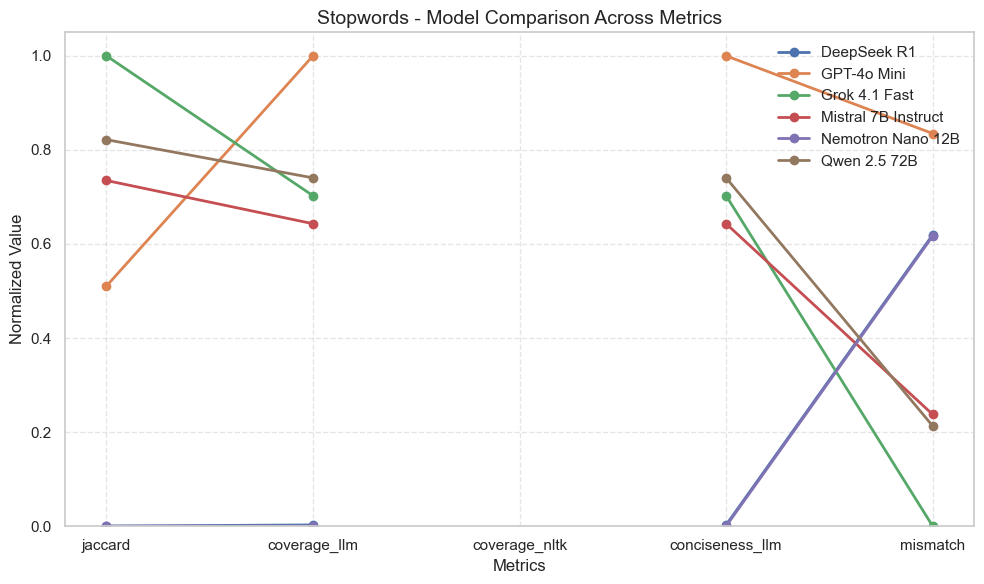

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load summary table
summary = pd.read_csv(r"excel sheets\Tasked_based_metrics_summary_table.csv")

# Metrics to plot
metrics = ["jaccard", "coverage_llm", "coverage_nltk", "conciseness_llm", "mismatch"]

# Normalize metrics to [0,1] for better comparison in line graph
norm_summary = summary.copy()
for m in metrics:
    norm_summary[m] = (norm_summary[m] - norm_summary[m].min()) / (norm_summary[m].max() - norm_summary[m].min())

# Line graph for each task
for task in summary["task"].unique():
    task_df = norm_summary[norm_summary["task"] == task]
    
    plt.figure(figsize=(10,6))
    
    for _, row in task_df.iterrows():
        values = row[metrics].tolist()
        plt.plot(metrics, values, marker='o', linewidth=2, label=row["model"])
    
    plt.title(f"{task.capitalize()} - Model Comparison Across Metrics", fontsize=14)
    plt.ylabel("Normalized Value")
    plt.xlabel("Metrics")
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"{task}_combined_line_graph.png")
    plt.show()


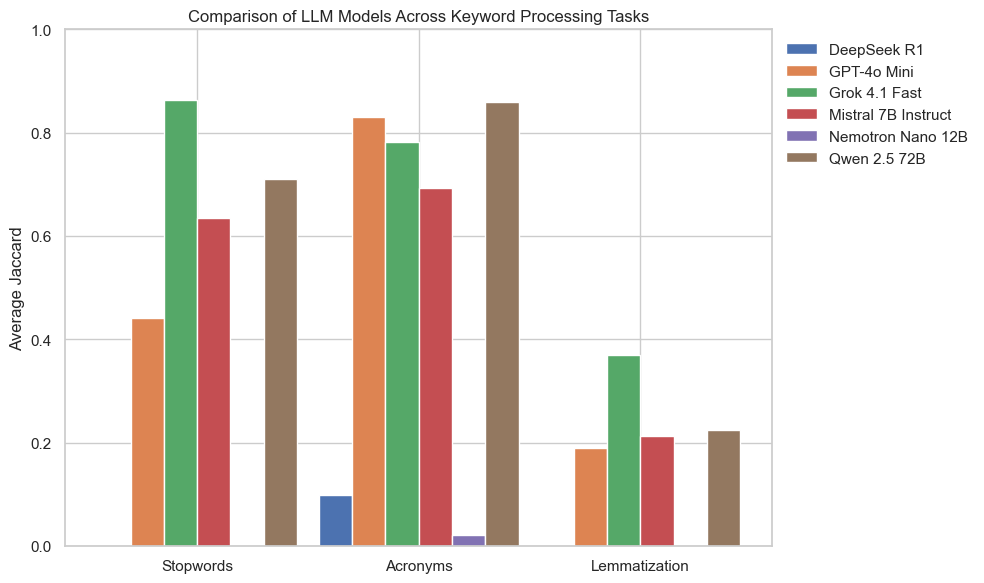

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load summary table
summary = pd.read_csv(r"excel sheets\Tasked_based_metrics_summary_table.csv")

# Focus only on Jaccard metric for clear comparison
metric_to_plot = "jaccard"

# Get unique models and tasks
models = summary["model"].unique()
tasks = ["stopwords", "acronyms", "lemmatization"]

# Prepare data for grouped bar chart
data = []
for model in models:
    row = []
    for task in tasks:
        value = summary[(summary["task"]==task) & (summary["model"]==model)][metric_to_plot].values
        if len(value) == 0:
            value = [0]
        row.append(value[0])
    data.append(row)

data = np.array(data)

# Plot
x = np.arange(len(tasks))  # task positions
width = 0.15  # width of each bar

plt.figure(figsize=(10,6))

for i, model in enumerate(models):
    plt.bar(x + i*width, data[i], width=width, label=model)

plt.xticks(x + width*(len(models)/2-0.5), [t.capitalize() for t in tasks])
plt.ylabel("Average Jaccard")
plt.title("Comparison of LLM Models Across Keyword Processing Tasks")
plt.ylim(0,1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("combined_task_comparison.png")
plt.show()
